In [0]:
# %run ./init

In [0]:
import re
import cv2
import numpy as np
import pandas as pd
import logging
import json
import os
import pytesseract
import pandas as pd
import logging
import json
from PIL import Image
import matplotlib.pyplot as plt
import math

In [0]:
# ---------------------------------------------------------------------
# Logger Setup
# ---------------------------------------------------------------------
logger = logging.getLogger("UnifiedExtractor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# ---------------------------------------------------------------------
# Utility Functions
# ---------------------------------------------------------------------
def dbfs_to_local_path(dbfs_path):
    """Convert a DBFS URI to a local path."""
    if dbfs_path.startswith("dbfs:/"):
        return "/dbfs/" + dbfs_path[len("dbfs:/"):]
    return dbfs_path


In [0]:
def read_cropped_section_image(section_path):
    """Read an image from a cropped section (handles DBFS paths)."""
    local_path = section_path
    if local_path.startswith("dbfs:"):
        local_path = local_path.replace("dbfs:", "")
    if local_path.startswith("/mnt/"):
        local_path = "/dbfs" + local_path
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to load image: {local_path}")
    logger.info(f"Image loaded from {local_path} with shape {img.shape}")
    return img

In [0]:
# -----------------------------------------------------------------------------
# COMMON UTILITY FUNCTIONS
# -----------------------------------------------------------------------------
def safe_read_image(img_path):
    local_path = img_path if not img_path.startswith("dbfs:") else img_path.replace("dbfs:", "/dbfs")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise ValueError(f"Failed to load image: {local_path}")
    logger.info(f"Image loaded from {local_path} with shape {img.shape}")
    return img

def preprocess_image(img, debug=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)
    if debug:
        logger.info("Preprocessing completed (grayscale and threshold applied).")
    return thresh

def detect_text_regions(thresh_img, debug=True):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        logger.info(f"Detected {len(rois)} text regions.")
    return rois

def perform_ocr_on_rois(img, rois, debug=True):
    """
    Performs OCR on each detected text region.
    Returns a list of tuples: (x, y, w, h, text).
    """
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip()
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box ({x},{y},{w},{h}): {text}")
    return results


In [0]:
# -----------------------------------------------------------------------------
# PARSING HELPERS
# -----------------------------------------------------------------------------
def group_ocr_results(roi_texts, row_tolerance=10):
    rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)
    row_strings = []
    for row in rows:
        row.sort(key=lambda c: c[0])
        line = " ".join(cell[4] for cell in row)
        row_strings.append(line)
    return row_strings

In [0]:
#DDR combo
def read_image_ddr(image_path):
    """
    Read an image from the given file path using OpenCV.
    
    If the provided path starts with 'dbfs:/', convert it to a local path by
    replacing the prefix with '/dbfs/'.
    """
    if image_path.startswith("dbfs:/"):
        local_path = "/dbfs/" + image_path[len("dbfs:/"):]
    else:
        local_path = image_path

    if not os.path.exists(local_path):
        raise FileNotFoundError(f"Image file not found at {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise ValueError(f"Failed to read image from {local_path}")
    return img

def draw_bounding_box_and_crop_ddr(image, coords, debug_path=None):
    """
    Crop the region defined by 'coords' (x, y, width, height).
    If a debug_path is provided, draw the bounding box on a copy and save it.
    """
    x, y, w, h = coords
    if debug_path:
        debug_img = image.copy()
        cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.imwrite(debug_path, debug_img)
        logger.info(f"Debug image saved to: {debug_path}")
    return image[y:y+h, x:x+w]

def preprocess_image_for_ocr_ddr(image):
    """
    Preprocess the image for OCR by converting it to grayscale, applying histogram equalization,
    Gaussian blur, and adaptive thresholding.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
    processed = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )
    return processed

def extract_key_value_from_text_ddr(text, expected_keys):
    """
    Extract key-value pairs from the OCR text based on expected keys.
    This function normalizes whitespace and uses regex to capture values.
    """
    combined = " ".join(line.strip() for line in text.splitlines() if line.strip())
    combined = re.sub(r'\s+', ' ', combined)
    result = {}
    for i, key in enumerate(expected_keys):
        if i < len(expected_keys) - 1:
            next_key = expected_keys[i+1]
            pattern = rf'{re.escape(key)}\s*:\s*(.*?)(?=\s*{re.escape(next_key)}\s*:|$)'
        else:
            pattern = rf'{re.escape(key)}\s*:\s*(.*)'
        match = re.search(pattern, combined, re.IGNORECASE)
        result[key] = match.group(1).strip() if match and match.group(1).strip() else None
    return result

def clean_report_num_ddr(report_num_str):
    """
    Remove any trailing punctuation from the Report Num (e.g., converts '11.' to '11').
    """
    if not report_num_str:
        return report_num_str
    match = re.search(r'^(\d+)\.?$', report_num_str)
    return match.group(1) if match else report_num_str

def process_daily_drilling_report(image_path, debug=True):
    """
    Process the Daily Drilling Report section.
    
    Expected output format:
    {
        "DAILY DRILLING REPORT": {
            "Report Date": "7/4/2024",
            "Report Num": "11",
            "Rig": "Cyclone 39"
        }
    }
    
    Steps:
      1. Read the image from the provided local path.
      2. Crop the top-right region where DDR details are located.
      3. Preprocess the cropped region for OCR.
      4. Perform OCR to extract text.
      5. Extract and clean key-value pairs.
    """
    logger.info(f"Processing DDR image from: {image_path}")
    img = read_image_ddr(image_path)
    
    # Coordinates for the top-right region; adjust as needed
    coords = (1600, 0, 950, 185)
    debug_path = "/dbfs/mnt/mini-proj-dd/final_ocr_results/debug_top_right.png"
    cropped = draw_bounding_box_and_crop_ddr(img, coords, debug_path=debug_path)
    
    processed = preprocess_image_for_ocr_ddr(cropped)
    ocr_text = perform_ocr(processed)
    logger.info("DDR OCR extraction complete.")
    logger.info(f"OCR Text:\n{ocr_text}")
    
    expected_keys = ["Report Date", "Report Num", "Rig"]
    extracted = extract_key_value_from_text_ddr(ocr_text, expected_keys)
    if extracted.get("Report Num"):
        extracted["Report Num"] = clean_report_num_ddr(extracted["Report Num"])
    
    df = pd.DataFrame(list(extracted.items()), columns=["Key", "Value"])
    return {"DAILY DRILLING REPORT": extracted}, df

def save_output(section_name, data_json, df, output_folder):
    """
    Save JSON and CSV output files for a section.
    """
    file_base = section_name.lower().replace(" ", "_").replace(":", "").replace("&", "and")
    json_path = os.path.join(output_folder, f"{file_base}_data.json")
    csv_path = os.path.join(output_folder, f"{file_base}_data.csv")
    with open(json_path, "w") as f:
        json.dump(data_json, f, indent=4)
    df.to_csv(csv_path, index=False)
    logger.info(f"{section_name} output saved to:\n JSON: {json_path}\n CSV: {csv_path}")


In [0]:
def build_casing_dict_from_rois(roi_texts, expected_headers, debug=True):
    row_strings = group_ocr_results(roi_texts)
    all_lines = []
    for line in row_strings:
        for sub in line.split("\n"):
            sub = sub.strip()
            if sub:
                all_lines.append(sub)
    data_lines = []
    for line in all_lines:
        tokens = re.split(r'\s{2,}', line)
        if len(tokens) == 1:
            tokens = line.split()
        lower_tokens = [t.lower() for t in tokens]
        if "type" in lower_tokens and "size" in lower_tokens:
            logger.info(f"CASING - Skipping header line: {tokens}")
            continue
        if len(tokens) < len(expected_headers):
            logger.warning(f"CASING - Line has fewer tokens than expected: {tokens}")
            continue
        tokens = tokens[:len(expected_headers)]
        data_lines.append(tokens)
    casing_list = [{expected_headers[i]: tokens[i] for i in range(len(expected_headers))}
                   for tokens in data_lines]
    return casing_list

def detect_text_regions_casing(thresh_img, debug=True):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    # Sort by y (top-to-bottom) then by x (left-to-right)
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        # show_image("3) Detected Regions", debug_img)
    return rois

def process_casing(img_path, debug=True):
    img = safe_read_image(img_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions_casing(thresh, debug=debug)
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    expected_headers = ["Type", "Size", "Weight", "Grade", "Connection", "Top MD", "Bottom MD", "TOC"]
    casing_list = build_casing_dict_from_rois(roi_texts, expected_headers, debug=debug)
    # df = pd.DataFrame(casing_list)
    # logger.info(f"CASING DataFrame shape: {df.shape}")
    return {"CASING": casing_list}, df

In [0]:
# -----------------------------------------------------------------------------
# process FUNCTIONS
# -----------------------------------------------------------------------------
def extract_key_value_from_text_cost(text, expected_keys):
    """
    Extracts key-value pairs from the text, ensuring that keys with empty values
    are correctly detected instead of capturing the next key as their value.
    """
    combined = " ".join(line.strip() for line in text.splitlines() if line.strip())
    combined = re.sub(r'\s+', ' ', combined)  # Normalize whitespace

    result = {}
    for i, key in enumerate(expected_keys):
        if i < len(expected_keys) - 1:
            next_key = expected_keys[i+1]
            pattern = rf'{re.escape(key)}\s*:\s*(.*?)(?=\s*{re.escape(next_key)}\s*:|$)'
        else:
            pattern = rf'{re.escape(key)}\s*:\s*(.*)'

        match = re.search(pattern, combined, re.IGNORECASE)
        if match:
            value = match.group(1).strip()
            result[key] = value if value else None  # Assign None for empty values
        else:
            result[key] = None  # Explicitly mark missing values

    return result

def process_cost_data(img_path, debug=True):
    #section_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_13.png"
    img = safe_read_image(img_path)
    ocr_text = perform_ocr(img)
    logger.info("Cost OCR extraction complete.")
    expected_keys = [
        "Drilling AFE Amount", "Daily Drilling Cost", "Cumulative Drilling Cost",
        "Cumulative Well Cost", "Daily Mud Cost", "Cumulative Mud Cost"
    ]
    extracted = extract_key_value_from_text_cost(ocr_text, expected_keys)
    df = pd.DataFrame(list(extracted.items()), columns=["Key", "Value"])
    logger.info(f"COST DataFrame shape: {df.shape}")
    return {"COST DATA": extracted}, df

In [0]:
def process_well_job_info(section_path, debug=True):
    img = safe_read_image(section_path)
    ocr_text = perform_ocr(img)
    logger.info("Well/Job OCR extraction complete.")
    expected_keys = [
        "Well Name", "Job Name", "Supervisor(s)", "Field", "Sec/Twn/Rng", "Phone",
        "AFE #", "API #", "Email", "Contractor", "Elevation", "RKB",
        "Spud Date", "Days from Spud", "Days on Loc", "MD/TVD", "24 Hr Footage",
        "Present Operations", "Activity Planned"
    ]
    combined = " ".join(line.strip() for line in ocr_text.splitlines() if line.strip())
    combined = re.sub(r'\s+', ' ', combined)
    result = {}
    for i, key in enumerate(expected_keys):
        if i < len(expected_keys) - 1:
            next_key = expected_keys[i+1]
            pattern = re.escape(key) + r'\s*:\s*(.*?)(?=\s*' + re.escape(next_key) + r'\s*:|$)'
        else:
            pattern = re.escape(key) + r'\s*:\s*(.*)'
        match = re.search(pattern, combined, re.IGNORECASE)
        result[key] = match.group(1).strip() if match else ""
    df = pd.DataFrame(list(result.items()), columns=["Key", "Value"])
    logger.info(f"WELL/JOB DataFrame shape: {df.shape}")
    return {"WELL/JOB INFORMATION": result}, df

In [0]:
def process_obs_int(section_path, debug=True):
    img = safe_read_image(section_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions(thresh, debug=debug)
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    header_str = "daily numbers: observation & intervention"
    all_texts = [t[4] for t in roi_texts]
    types_list, numbers_list = [], []
    for txt in all_texts:
        clean = txt.strip()
        if clean.lower() in [header_str, "number", "[blank]"]:
            continue
        try:
            float(clean)
            numbers_list.append("" if clean.lower() == "[blank]" else clean)
            continue
        except ValueError:
            pass
        if "\n" in clean:
            for line in clean.splitlines():
                line = line.strip()
                if line and line.lower() != "[blank]":
                    types_list.append(line)
        else:
            types_list.append(clean)
    expected_count = 5
    while len(numbers_list) < expected_count:
        numbers_list.append("")
    types_list = types_list[:expected_count]
    numbers_list = numbers_list[:expected_count]
    structured = [{"Type": types_list[i], "Number": numbers_list[i]} for i in range(expected_count)]
    df = pd.DataFrame(structured)
    logger.info(f"DAILY NUMBERS: OBSERVATION & INTERVENTION DataFrame shape: {df.shape}")
    return {"DAILY NUMBERS: OBSERVATION & INTERVENTION": structured}, df


In [0]:
def build_dir_info_dict_from_rois(roi_texts, debug=True):
    all_texts = [t[4] for t in roi_texts]
    daily_cum_idx = next((i for i, txt in enumerate(all_texts)
                           if "daily" in txt.lower() and "cumulative" in txt.lower()), None)
    if daily_cum_idx is None:
        logger.warning("Could not find 'Daily Cumulative' bounding box.")
        return {}, pd.DataFrame()
    cat_idx = daily_cum_idx + 1
    if cat_idx >= len(all_texts):
        logger.warning("No bounding box after 'Daily Cumulative'.")
        return {}, pd.DataFrame()
    categories_box = all_texts[cat_idx]
    lines = [ln.strip() for ln in categories_box.split("\n") if ln.strip()]
    if len(lines) < 5:
        logger.warning(f"Expected 5 category lines, got {len(lines)}: {lines}")
    def safe_get(idx):
        return all_texts[idx] if 0 <= idx < len(all_texts) else ""
    structured = []
    for i in range(4):
        cat_name = lines[i] if i < len(lines) else f"Unknown Category {i+1}"
        daily_box = safe_get(cat_idx + 1 + (i * 2))
        cum_box = safe_get(cat_idx + 2 + (i * 2))
        structured.append({
            "Category": cat_name,
            "Daily": "" if daily_box == "[BLANK]" else daily_box,
            "Cumulative": "" if cum_box == "[BLANK]" else cum_box
        })
    last_box = safe_get(cat_idx + 9)
    last_cat = lines[4] if len(lines) >= 5 else "Rotating Footage"
    remainder = last_box.replace(last_cat, "").strip()
    tokens = remainder.split()
    daily_val = tokens[0] if len(tokens) >= 2 else ""
    cum_val = tokens[1] if len(tokens) >= 2 else ""
    structured.append({
        "Category": last_cat,
        "Daily": "" if daily_val == "[BLANK]" else daily_val,
        "Cumulative": "" if cum_val == "[BLANK]" else cum_val
    })
    df = pd.DataFrame(structured)
    logger.info(f"DIR INFO DataFrame shape: {df.shape}")
    return {"DIR INFO": structured}, df

def process_dir_info(section_path, debug=True):
    img = safe_read_image(section_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions(thresh, debug=debug)
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    return build_dir_info_dict_from_rois(roi_texts, debug=debug)

In [0]:
def detect_text_regions_consumables(thresh_img, debug=True):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # A basic size filter to skip very small or very thin boxes
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    # Sort by y then x
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        # show_image("3) Detected Regions", debug_img)
    return rois


def build_consumables_dict_from_rois(roi_texts, debug=True):
    row_strings = group_ocr_results(roi_texts)
    data_rows = []
    for line in row_strings:
        lower_line = line.lower()
        if ("consumable" in lower_line and "received" in lower_line) or "nun" in lower_line:
            continue
        if len(line.split()) < 5:
            continue
        data_rows.append(line)
    consumables_list = []
    for line in data_rows:
        tokens = re.split(r'\s+', line)
        if len(tokens) > 5:
            first = " ".join(tokens[:-4])
            tokens = [first] + tokens[-4:]
        if len(tokens) != 5:
            logger.warning(f"CONSUMABLES - Skipping row (unexpected token count): {tokens}")
            continue
        consumables_list.append({
            "Consumable": tokens[0],
            "Daily Received (gal)": tokens[1],
            "Daily Used (gal)": tokens[2],
            "Cumulative Used (gal)": tokens[3],
            "Daily on Hand (gal)": tokens[4]
        })
    return consumables_list

def process_consumables_data(img_path, debug=True):
    #section_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_2_section_2.png"
    img = safe_read_image(img_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions_consumables(thresh, debug=debug)
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    consumables_list = build_consumables_dict_from_rois(roi_texts, debug=debug)
    df = pd.DataFrame(consumables_list)
    logger.info(f"CONSUMABLES DataFrame shape: {df.shape}")
    return {"CONSUMABLES": consumables_list}, df


In [0]:
def extract_bha_data(image_path, debug=True):
    image = Image.open(image_path)
    ocr_text = pytesseract.image_to_string(image)
    patterns = {
        "Drill Pipe Detail": r"Drill Pipe Detail:\s*([^\n]+)",
        "Size": r"Size:\s*([\d.]+)\b",
        "Wt./Ft": r"Wt\./Ft:\s*([\d.]+)\b",
        "Connection": r"Connection:\s*([\w\d-]+)\b",
        "ID": r"ID:\s*([\d.]+)\b",
        "Drill Bit": r"Drill Bit:\s*([^\n;]+)",
        "Motor": r"Motor:\s*([^\n;]+)",
        "MWD Tool": r"MWD Tool:\s*([^\n;]+)",
        "Monel Collar": r"Monel Collar:\s*([^\n;]+)",
        "X-Over": r"X-Over:\s*([^\n;]+)",
        "Sub": r"Sub:\s*([^\n;]+)",
        "HWDP": r"HWDP:\s*([^\n;]+)",
        "Drill Pipe": r"Drill Pipe:\s*([\d.]+(?:\" DP)?)",
        "Reamer": r"Reamer:\s*([^\n;]+)",
        "Shock Sub": r"Shock Sub:\s*([^\n;]+)",
        "Total Length": r"Total Length:\s*(\d+)\b"
    }
    bha_data = {}
    for key, pat in patterns.items():
        match = re.search(pat, ocr_text)
        if match:
            bha_data[key] = match.group(1).strip()
    if "Drill Pipe Detail" in bha_data:
        detail = bha_data["Drill Pipe Detail"]
        for remove_key in ["Size", "Wt./Ft", "Connection", "ID"]:
            if remove_key in bha_data:
                detail = re.sub(rf"{remove_key}:\s*{re.escape(bha_data[remove_key])}", "", detail).strip(",; ")
        bha_data["Drill Pipe Detail"] = detail
    structured_data = {
        "BHA": {
            "Drill Pipe Detail": bha_data.get("Drill Pipe Detail", ""),
            "Size": bha_data.get("Size", ""),
            "Wt./Ft": bha_data.get("Wt./Ft", ""),
            "Connection": bha_data.get("Connection", ""),
            "ID": bha_data.get("ID", ""),
            "BHA #4": {
                "Drill Bit": bha_data.get("Drill Bit", ""),
                "Motor": bha_data.get("Motor", ""),
                "MWD Tool": bha_data.get("MWD Tool", ""),
                "Monel Collar": bha_data.get("Monel Collar", ""),
                "X-Over": bha_data.get("X-Over", ""),
                "Sub": bha_data.get("Sub", ""),
                "HWDP": bha_data.get("HWDP", ""),
                "Drill Pipe": bha_data.get("Drill Pipe", ""),
                "Reamer": bha_data.get("Reamer", ""),
                "Shock Sub": bha_data.get("Shock Sub", "")
            },
            "Total Length": bha_data.get("Total Length", "")
        }
    }
    if debug:
        logger.info("Extracted BHA data:")
        logger.info(json.dumps(structured_data, indent=4))
    return structured_data

def process_bha_data(image_path, debug=True):
    #image_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png"  # Adjust as needed
    #bha_json = extract_bha_data(image_path, debug=debug)
    img = safe_read_image(image_path)
    ocr_text = perform_ocr(img)
    pump_data = parse_pumps_table(ocr_text)
    circ_data = parse_drilling_circ_rates(ocr_text)
    pumps_df = pd.DataFrame(pump_data)
    circ_df = pd.DataFrame(circ_data)
    bha_df = pd.DataFrame([bha_json])
    logger.info(f"BHA DataFrame shape: {bha_df.shape}")
    combined = {"BHA": bha_json, "Pumps": pump_data, "DrillingCircRates": circ_data}
    return combined, pumps_df, circ_df, bha_df

In [0]:
def process_mud_data(img_path, debug=True):
    #section_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_3.png"
    img = safe_read_image(img_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions(thresh, debug=debug)
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    expected_headers = [
        "Type", "Weight In", "Weight Out", "pH", "CAKE",
        "GELS (10s/10m/30m)", "Oil/Water", "FV", "ES", "PV",
        "YP", "CL", "Ca", "LGS", "WL", "HTHP Loss", "3 RPM",
        "6 RPM", "Mud Pits and Hole Volume", "24 Hr Loss",
        "Total Loss", "Comments"
    ]
    mud_dict = build_mud_dict_from_rois(roi_texts, expected_headers)
    return {"MUD": mud_dict}, pd.DataFrame(list(mud_dict.items()), columns=["Key", "Value"])

# ---------------------------------------------------------------------
# parse_value_row_tokens for mud section
# ---------------------------------------------------------------------
def parse_value_row_tokens(expected_headers, tokens):
    """
    Map a flat list of tokens to the expected headers.
    For "GELS (10s/10m/30m)", consume 3 tokens and create a sub-dictionary.
    Expected token count = (number of headers - 1) + 3.
    """
    expected_token_count = (len(expected_headers) - 1) + 3
    logger.info(f"Expected token count: {expected_token_count}, tokens extracted: {tokens}")
    
    # Pad or trim tokens as needed.
    if len(tokens) < expected_token_count:
        tokens += ["[BLANK]"] * (expected_token_count - len(tokens))
        logger.warning("Not enough tokens. Padding with [BLANK].")
    elif len(tokens) > expected_token_count:
        tokens = tokens[:expected_token_count]
        logger.warning("Too many tokens. Trimming the extra tokens.")
    
    result = {}
    idx = 0
    for header in expected_headers:
        if header == "GELS (10s/10m/30m)":
            gels_tokens = tokens[idx:idx+3]
            result[header] = {
                "10s": gels_tokens[0],
                "10m": gels_tokens[1],
                "30m": gels_tokens[2]
            }
            idx += 3
        else:
            result[header] = tokens[idx]
            idx += 1
    logger.info(f"Mapped dictionary: {result}")
    return result

# ---------------------------------------------------------------------
# build_mud_dict_from_rois
# ---------------------------------------------------------------------
def build_mud_dict_from_rois(roi_texts, expected_headers):
    """
    Group OCR results into rows based on the y coordinate.
    Identify header rows and corresponding data rows.
    
    In our case, we expect:
      - A header row (with labels) followed by a data row,
      - Then a second header row (for the remaining fields) followed by a second data row.
    
    We then combine the two data rows' tokens and map them to expected_headers.
    """
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None

    # Group by row based on y coordinate.
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)

    # Sort each row by x coordinate and log its text.
    row_strings = []
    for i, row_cells in enumerate(rows):
        row_cells.sort(key=lambda c: c[0])
        line_text = " ".join(cell[4] for cell in row_cells)
        row_strings.append(line_text)
        logger.info(f"Row {i} text: {line_text}")

    # Based on OCR output expectations:
    # Row 1: header row 1 (first set of labels)
    # Row 2: data row 1 (first set of values)
    # Row 3: header row 2 (remaining labels)
    # Row 4: data row 2 (remaining values)
    header1_line = None
    value1_line = None
    header2_line = None
    value2_line = None

    for i, r_text in enumerate(row_strings):
        if "Type" in r_text and not header1_line:
            header1_line = r_text
            if i + 1 < len(row_strings):
                value1_line = row_strings[i+1]
        elif header1_line and not header2_line and any(kw in r_text for kw in ["RPM", "Mud", "Loss", "Comments"]):
            header2_line = r_text
            if i + 1 < len(row_strings):
                value2_line = row_strings[i+1]
            break

    logger.info(f"Header1: {header1_line}")
    logger.info(f"Value1: {value1_line}")
    logger.info(f"Header2: {header2_line}")
    logger.info(f"Value2: {value2_line}")

    if value1_line is None:
        logger.error("No data row found for header1!")
        return {}

    # Split the data rows into tokens.
    tokens1 = value1_line.split()
    tokens2 = value2_line.split() if value2_line else []
    logger.info(f"Tokens from data row 1: {tokens1}")
    logger.info(f"Tokens from data row 2: {tokens2}")

    # Combine tokens from both data rows.
    combined_tokens = tokens1 + tokens2
    logger.info(f"Combined tokens: {combined_tokens}")

    # Map the tokens to the expected headers.
    return parse_value_row_tokens(expected_headers, combined_tokens)

In [0]:
# ---------------------------------------------------------------------
# Pumps Extraction process
# ---------------------------------------------------------------------

def parse_pumps_table(ocr_text):
    """
    Parses the pumps table from OCR text using a regex.
    Expected format: Number BOMCO TRIPLEX [HHP] Efficiency Stroke(in) Liner(in) P-Rating P-Limit SPM_Rating SPM_Limit
    """
    pump_pattern = re.compile(
        r"^(\d+)?\s*"               # Number (optional)
        r"(BOMCO)\s+(TRIPLEX)\s+"    # Model, Type
        r"(\d+)?\s*"                # HHP (optional)
        r"(\d+)\s+"                 # Efficiency
        r"([\d.]+)\s+"              # Stroke\(in\)
        r"([\d.]+)\s+"              # Liner\(in\)
        r"(\d+)\s+"                 # P-Rating\(psi\)
        r"(\d+)\s+"                 # P-Limit\(psi\)
        r"(\d+)\s+"                 # SPM Rating
        r"(\d+)\s*$",               # SPM Limit
        re.IGNORECASE
    )
    pumps = []
    lines = ocr_text.splitlines()
    for line in lines:
        line = line.strip()
        match = pump_pattern.match(line)
        if match:
            number, model, pump_type, hhp, efficiency, stroke, liner, p_rating, p_limit, spm_rating, spm_limit = match.groups()
            pumps.append({
                "Number": number if number else "",
                "Model": model,
                "Type": pump_type,
                "HHP": hhp if hhp else "",
                "Efficiency": efficiency,
                "Stroke(in)": stroke,
                "Liner(in)": liner,
                "P-Rating(psi)": p_rating,
                "P-Limit(psi)": p_limit,
                "SPM Rating": spm_rating,
                "SPM Limit": spm_limit
            })
    return pumps

def parse_drilling_circ_rates(ocr_text):
    """
    Parses drilling/circ rates from OCR text.
    This version splits the text into segments starting with "Drilling/Circ Rate <n>"
    then combines the lines in each segment and applies a regex with DOTALL.
    """
    circ_rates = []
    
    # Split the OCR text into segments where each segment begins with "Drilling/Circ Rate" followed by a digit
    segments = re.split(r"(?=Drilling/Circ Rate \d+)", ocr_text)
    
    # Regex pattern to capture the numbers:
    # Group 1: Rate ID (the number after "Drilling/Circ Rate")
    # Group 2: Pressure (number preceding "PS!" or "PSI")
    # Group 3: SPM value (number after "@")
    # Group 4: Gal/Stoke value
    # Group 5: GPM value
    # Group 6: BPM value
    # Group 7: DC value
    # Group 8: DP value
    pattern = re.compile(
        r"Drilling/Circ Rate\s+(\d+).*?"       # Rate ID
        r"(\d+)\s+PS[!I].*?"                   # Pressure
        r"@\s*(\d+).*?"                        # SPM value
        r"([\d.]+)\s+Gal/Stoke.*?"              # Gal/Stoke
        r"([\d.]+)\s+GPM.*?"                    # GPM
        r"([\d.]+)\s+BPM.*?"                    # BPM
        r"([\d.]+)\s+DC.*?"                     # DC
        r"([\d.]+)\s+DP",                      # DP
        re.IGNORECASE | re.DOTALL
    )
    
    # Process each segment individually
    for seg in segments:
        seg = seg.strip()
        if not seg.startswith("Drilling/Circ Rate"):
            continue  # Skip any header or unrelated segments
        # Replace newline characters with spaces to form a continuous string
        seg_clean = " ".join(seg.splitlines())
        match = pattern.search(seg_clean)
        if match:
            rate_id, pressure, spm, gal_stroke, gpm, bpm, dc, dp = match.groups()
            circ_rates.append({
                "RateID": rate_id,
                "Pressure(PSI)": pressure,
                "SPM": spm,
                "Gal/Stoke": gal_stroke,
                "GPM": gpm,
                "BPM": bpm,
                "DC": dc,
                "DP": dp
            })
        else:
            # Optional: log a warning if no match is found for a segment
            print(f"Warning: No match found in segment:\n{seg_clean}")
            
    return circ_rates


def process_pumps(pumps_img_path, debug=True):
    """
    Processes the pumps section:
    #   - Reads image using PIL,
      - Performs OCR,
      - Parses pumps table and drilling/circ rates,
      - Returns combined results as JSON and a DataFrame.
    """
    #pil_img = read_pil_image(pumps_img_path)
    ocr_text = perform_ocr(pil_img)
    if debug:
        logger.info("Pumps OCR Text:\n" + ocr_text)
    pumps = parse_pumps_table(ocr_text)
    circ_rates = parse_drilling_circ_rates(ocr_text)
    final_data = {"Pumps": pumps, "DrillingCircRates": circ_rates}
    df_pumps = pd.DataFrame(pumps)
    df_circ = pd.DataFrame(circ_rates)
    if not df_pumps.empty and not df_circ.empty:
        df = pd.concat([df_pumps, df_circ], axis=0, ignore_index=False)
    elif not df_pumps.empty:
        df = df_pumps
    else:
        df = df_circ
    return final_data, df

In [0]:
# --------------------------------------------------------
# 5) Personnel Extraction process
# --------------------------------------------------------
def detect_text_regions_personnel(thresh_img, debug=True):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    rois.sort(key=lambda b: (b[1], b[0]))
    logger.debug(f"Detected {len(rois)} text regions for personnel.")
    # if debug:
    #     show_image("Detected Personnel Text Regions", debug_img, size=(12, 12))
    return rois

def perform_ocr_on_rois_personnel(img, rois, debug=True):
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config='--psm 6').strip()
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        logger.debug(f"ROI bbox=({x}, {y}, {w}, {h}), text: '{text}'")
    return results

def group_rois_by_row(roi_results, threshold=20):
    roi_with_center = [(x, y, w, h, text, y + h/2) for (x, y, w, h, text) in roi_results]
    roi_with_center.sort(key=lambda r: r[5])
    groups = []
    current_group = []
    current_center = None
    for roi in roi_with_center:
        x, y, w, h, text, y_center = roi
        if current_center is None:
            current_center = y_center
            current_group.append((x, y, w, h, text))
        elif abs(y_center - current_center) < threshold:
            current_group.append((x, y, w, h, text))
        else:
            groups.append(current_group)
            current_group = [(x, y, w, h, text)]
            current_center = y_center
    if current_group:
        groups.append(current_group)
    logger.debug(f"Grouped ROIs into {len(groups)} rows.")
    return groups

def preprocess_personnel_data_from_rows(groups):
    personnel_data = []
    header_lines = {
        "personnel", 
        "company contractor no. personnel daily hours cumulative hours",
        "ssn"
    }
    for group in groups:
        group.sort(key=lambda r: r[0])
        row_text = " ".join([r[4] for r in group]).strip()
        logger.debug(f"Processing row: '{row_text}'")
        if row_text.lower() in header_lines:
            logger.debug("Skipping header row.")
            continue
        tokens = row_text.split()
        numeric_tokens = re.findall(r'\d+(?:\.\d+)?', row_text)
        logger.debug(f"Row tokens: {tokens}")
        logger.debug(f"Numeric tokens found: {numeric_tokens}")
        if tokens[0].lower().startswith("totals"):
            if len(numeric_tokens) >= 2:
                try:
                    daily_hours = int(float(numeric_tokens[0]))
                    cumulative_hours = numeric_tokens[1]
                except ValueError as e:
                    logger.error(f"Error parsing Totals row: {row_text} => {e}")
                    continue
                row_dict = {
                    "Company": "",
                    "Contractor": "",
                    "No. Personnel": "Totals",
                    "Daily Hours": daily_hours,
                    "Cumulative Hours": cumulative_hours
                }
                logger.info(f"Totals row parsed: {row_dict}")
                personnel_data.append(row_dict)
            else:
                logger.warning(f"Totals row without sufficient numbers: {row_text}")
            continue
        if len(numeric_tokens) >= 3:
            try:
                no_personnel = int(float(numeric_tokens[-3]))
                daily_hours = int(float(numeric_tokens[-2]))
                cumulative_hours = int(float(numeric_tokens[-1]))
                logger.debug(f"Extracted: no_personnel={no_personnel}, daily_hours={daily_hours}, cumulative_hours={cumulative_hours}")
            except ValueError as e:
                logger.error(f"Error converting numbers in row: {row_text} => {e}")
                continue
            pattern = (r'\s*' + re.escape(numeric_tokens[-3]) +
                       r'\s+' + re.escape(numeric_tokens[-2]) +
                       r'\s+' + re.escape(numeric_tokens[-1]) + r'\s*$')
            text_only = re.sub(pattern, '', row_text).strip()
        elif len(numeric_tokens) == 1:
            try:
                cumulative_hours = int(float(numeric_tokens[0]))
                logger.debug(f"Single numeric token, cumulative_hours: {cumulative_hours}")
            except ValueError as e:
                logger.error(f"Error converting single number in row: {row_text} => {e}")
                continue
            no_personnel = None
            daily_hours = None
            pattern = r'\s*' + re.escape(numeric_tokens[0]) + r'\s*$'
            text_only = re.sub(pattern, '', row_text).strip()
        else:
            logger.warning(f"Row has unexpected number of numeric tokens: {row_text}")
            continue

        if "service company" in text_only.lower():
            parts = re.split(r'(?i)service company', text_only, maxsplit=1)
            company = parts[0].strip()
            contractor = "Service Company"
        else:
            company = text_only
            contractor = "Service Company"
        
        row_dict = {
            "Company": company,
            "Contractor": contractor,
            "No. Personnel": no_personnel,
            "Daily Hours": daily_hours,
            "Cumulative Hours": cumulative_hours
        }
        logger.info(f"Parsed row: {row_dict}")
        personnel_data.append(row_dict)
    return {"PERSONNEL": personnel_data}

def process_personnel(personnel_img_path, debug=True):
    """Processes the personnel section: read image, detect ROIs, OCR, group and parse rows."""
    img = read_cropped_section_image(personnel_img_path)
    # if debug:
        # show_image("Original Personnel Image", img, size=(10,10))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
    # if debug:
        # show_image("Thresholded Personnel Image", cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR), size=(8,8))
    rois = detect_text_regions_personnel(thresh_img, debug=debug)
    roi_results = perform_ocr_on_rois_personnel(img, rois, debug=debug)
    grouped_rows = group_rois_by_row(roi_results, threshold=20)
    data_dict = preprocess_personnel_data_from_rows(grouped_rows)
    df = pd.DataFrame(data_dict["PERSONNEL"]) if data_dict["PERSONNEL"] else pd.DataFrame(
        columns=["Company", "Contractor", "No. Personnel", "Daily Hours", "Cumulative Hours"])
    return data_dict, df

In [0]:
# ---------------------------------------------------------------------
# 3) Survey Extraction process
# ---------------------------------------------------------------------
def build_survey_dict_from_rois(roi_texts, expected_headers):
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)
    
    row_strings = []
    for i, row in enumerate(rows):
        row.sort(key=lambda cell: cell[0])
        line = " ".join(cell[4] for cell in row)
        row_strings.append(line)
        logger.info(f"Grouped Row {i}: {line}")
    
    all_lines = []
    for line in row_strings:
        for subline in line.split("\n"):
            subline = subline.strip()
            if subline:
                all_lines.append(subline)
    logger.info(f"All extracted lines: {all_lines}")
    
    data_lines = []
    for line in all_lines:
        tokens = re.split(r'\s{2,}', line)
        if len(tokens) == 1:
            tokens = line.split()
        lower_tokens = [t.lower() for t in tokens]
        if "md" in lower_tokens and "inclination" in lower_tokens:
            logger.info(f"Skipping header line: {tokens}")
            continue
        if len(tokens) < len(expected_headers):
            logger.warning(f"Line has fewer tokens than expected: {tokens}")
            continue
        tokens = tokens[:len(expected_headers)]
        data_lines.append(tokens)
    
    survey_list = []
    for tokens in data_lines:
        row_dict = {expected_headers[i]: tokens[i] for i in range(len(expected_headers))}
        survey_list.append(row_dict)
    return survey_list

def sort_survey_data(survey_list):
    def md_value(row):
        try:
            return float(row["MD"].replace(",", ""))
        except Exception:
            return 0
    sorted_list = sorted(survey_list, key=md_value, reverse=False)
    filtered_list = [row for row in sorted_list if not row["MD"].upper().startswith("SURVEY")]
    return filtered_list

def process_survey(survey_img_path, debug=True):
    expected_headers = ["MD", "Inclination", "Azimuth", "DLS", "TVD"]
    img = safe_read_image(survey_img_path)
    # if debug:
        # show_image("Original Survey Image", img, size=(12,12))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 9
    )
    # if debug:
        # show_image("Adaptive Threshold", thresh, cmap="gray")
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        show_image("Detected Text Regions", debug_img)
    roi_texts = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip()
        if not text:
            text = "[BLANK]"
        roi_texts.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box ({x},{y},{w},{h}): {text}")
    survey_list = build_survey_dict_from_rois(roi_texts, expected_headers)
    survey_list = sort_survey_data(survey_list)
    final_output = {"SURVEY DATA": survey_list}
    df = pd.DataFrame(survey_list)
    return final_output, df

# ---------------------------------------------------------------------
# 4) BOP Extraction process
# ---------------------------------------------------------------------
def process_bop(ocr_text, debug= True):
    pattern = {
        "Last BOP Test Date": r"Last BOP Test Date\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Last BOP Drill": r"Last BOP Drill\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Next BOP Test": r"Next BOP Test\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})"
    }
    result = {}
    for key, regex in pattern.items():
        match = re.search(regex, ocr_text, re.IGNORECASE)
        result[key] = match.group(1) if match else ""
    return result

def process_bop(section_path, debug=False):
    img = safe_read_image(section_path)
    ocr_text = perform_ocr(img)
    logger.info("BOP OCR extraction complete.")
    patterns = {
        "Last BOP Test Date": r"Last BOP Test Date\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Last BOP Drill": r"Last BOP Drill\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Next BOP Test": r"Next BOP Test\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})"
    }
    result = {}
    for key, regex in patterns.items():
        match = re.search(regex, ocr_text, re.IGNORECASE)
        result[key] = match.group(1) if match else ""
    df = pd.DataFrame(list(result.items()), columns=["Key", "Value"])
    logger.info(f"BOP DataFrame shape: {df.shape}")
    return {"BOP": result}, df

# ---------------------------------------------------------------------
# 6) BHA Extraction process
# ---------------------------------------------------------------------
def extract_bha_data(image_path):
    image = Image.open(image_path)
    ocr_text = pytesseract.image_to_string(image)
    patterns = {
        "Drill Pipe Detail": r"Drill Pipe Detail:\s*([^\n]+)",
        "Size": r"Size:\s*([\d.]+)\b",
        "Wt./Ft": r"Wt\./Ft:\s*([\d.]+)\b",
        "Connection": r"Connection:\s*([\w\d-]+)\b",
        "ID": r"ID:\s*([\d.]+)\b",
        "Drill Bit": r"Drill Bit:\s*([^\n;]+)",
        "Motor": r"Motor:\s*([^\n;]+)",
        "MWD Tool": r"MWD Tool:\s*([^\n;]+)",
        "Monel Collar": r"Monel Collar:\s*([^\n;]+)",
        "X-Over": r"X-Over:\s*([^\n;]+)",
        "Sub": r"Sub:\s*([^\n;]+)",
        "HWDP": r"HWDP:\s*([^\n;]+)",
        "Drill Pipe": r"Drill Pipe:\s*([\d.]+(?:\" DP)?)",
        "Reamer": r"Reamer:\s*([^\n;]+)",
        "Shock Sub": r"Shock Sub:\s*([^\n;]+)",
        "Total Length": r"Total Length:\s*(\d+)\b"
    }
    bha_data = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, ocr_text)
        if match:
            bha_data[key] = match.group(1).strip()
    if "Drill Pipe Detail" in bha_data:
        detail = bha_data["Drill Pipe Detail"]
        for remove_key in ["Size", "Wt./Ft", "Connection", "ID"]:
            if remove_key in bha_data:
                detail = re.sub(rf"{remove_key}:\s*{re.escape(bha_data[remove_key])}", "", detail).strip(",; ")
        bha_data["Drill Pipe Detail"] = detail
    structured_data = {
        "BHA": {
            "Drill Pipe Detail": bha_data.get("Drill Pipe Detail", ""),
            "Size": bha_data.get("Size", ""),
            "Wt./Ft": bha_data.get("Wt./Ft", ""),
            "Connection": bha_data.get("Connection", ""),
            "ID": bha_data.get("ID", ""),
            "BHA #4": {
                "Drill Bit": bha_data.get("Drill Bit", ""),
                "Motor": bha_data.get("Motor", ""),
                "MWD Tool": bha_data.get("MWD Tool", ""),
                "Monel Collar": bha_data.get("Monel Collar", ""),
                "X-Over": bha_data.get("X-Over", ""),
                "Sub": bha_data.get("Sub", ""),
                "HWDP": bha_data.get("HWDP", ""),
                "Drill Pipe": bha_data.get("Drill Pipe", ""),
                "Reamer": bha_data.get("Reamer", ""),
                "Shock Sub": bha_data.get("Shock Sub", "")
            },
            "Total Length": bha_data.get("Total Length", "")
        }
    }
    return structured_data

def process_bha(bha_img_path, debug=True):
    bha_json = extract_bha_data(bha_img_path)
    df = pd.json_normalize(bha_json["BHA"])
    return {"BHA": bha_json["BHA"]}, df

In [0]:

# ---------------------------------------------------------------------
# build_bit_info_dict_from_rois
# ---------------------------------------------------------------------
def build_bit_info_dict_from_rois(roi_texts, debug=True):
    """
    Custom parsing for the multi-row header layout:
      Row 0 => Table Title (e.g. "DRILL BITS ...")
      Row 1 => Super Headers: "Bit Data  Nozzles  Depth  Hours  Dull Grade"
      Row 2 => Sub-headers:   "Bit # Size Make Model Serial #  Number x Size TFA  In Out Feet ROP  Total On Btm  I oO D L B G oO RP"
      Row 3 => Data row #1
      Row 4 => Data row #2
      ...
    We'll parse row 1 and row 2 to define column groups. Then parse each subsequent row in chunks.
    """
    # Step 1) Group bounding boxes by y-coordinate
    row_tolerance = 10
    grouped_rows = []
    current_row = []
    prev_y = None

    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            grouped_rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        grouped_rows.append(current_row)

    # Step 2) Convert each row group into a single string
    row_strings = []
    for i, row_cells in enumerate(grouped_rows):
        row_cells.sort(key=lambda c: c[0])  # left->right
        line = " ".join(cell[4] for cell in row_cells)
        line = line.replace("\n", " ").strip()  # flatten
        row_strings.append(line)
        if debug:
            logger.info(f"Row {i} => {line}")

    # We expect something like:
    # Row 0 => "DRILL BITS DRILL BITS [BLANK]"
    # Row 1 => "Bit Data Nozzles Depth Hours Dull Grade"
    # Row 2 => "Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm I oO D L B G oO RP"
    # Row 3 => "4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 ..."
    # Row 4 => "3 9.875 REED TKS6-H1 A308739 7X12 0.77 ..."

    # Step 3) Identify the row indices for:
    #  - Title (row 0)
    #  - Super headers (row 1)
    #  - Sub-headers (row 2)
    #  - Data rows (row 3, 4, ...)
    if len(row_strings) < 3:
        logger.warning("Not enough rows found for this layout.")
        return [], pd.DataFrame()

    # We'll skip row 0 (table title).
    super_header_line = row_strings[1] if len(row_strings) > 1 else ""
    sub_header_line   = row_strings[2] if len(row_strings) > 2 else ""
    data_lines        = row_strings[3:]  # everything after row 2

    if debug:
        logger.info(f"Super Headers => {super_header_line}")
        logger.info(f"Sub Headers => {sub_header_line}")
        logger.info(f"Data Lines => {data_lines}")

    # Step 4) Define the "super header" groups and sub-headers
    # We'll do a simpler approach: we know how many tokens each group has:
    #  Bit Data => 5, Nozzles => 2, Depth => 4, Hours => 2, Dull Grade => 8 (Total = 21)
    final_columns = [
        "Bit #", "Size", "Make", "Model", "Serial #",         # 5
        "Nozzle-(Number x Size)", "Nozzle-TFA",               # 2
        "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",   # 4
        "Hours-Total", "Hours-On Btm",                        # 2
        "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L", 
        "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"  # 8
    ]

    # Step 5) Parse each data row in chunks of 21 tokens
    structured_data = []
    for line in data_lines:
        tokens = line.split()
        # We expect 21 tokens per data row; pad or truncate if necessary
        if len(tokens) < 21:
            tokens += [""] * (21 - len(tokens))
        elif len(tokens) > 21:
            tokens = tokens[:21]

        row_dict = {}
        for col_idx, col_name in enumerate(final_columns):
            row_dict[col_name] = tokens[col_idx] if col_idx < len(tokens) else ""

        structured_data.append(row_dict)
        if debug:
            logger.info(f"Parsed row => {row_dict}")

    # Step 6) Convert to DataFrame and JSON
    df = pd.DataFrame(structured_data)
    if debug:
        logger.info("DataFrame Preview:")
        logger.info(df.head())

    df.to_csv("bit_info_data.csv", index=False)
    logger.info("Data saved successfully as CSV.")

    structured_data_json = df.to_dict(orient='records')
    with open("bit_info_data.json", "w") as json_file:
        json.dump(structured_data_json, json_file, indent=4)
    logger.info("Data saved successfully in JSON format.")

    return structured_data_json, df

# ---------------------------------------------------------------------
# main_bit_info_pipeline
# ---------------------------------------------------------------------
def process_drill_bits(img_path, debug=True):
    """
    Main pipeline for extracting the BIT DETAILS table from your layout.
    """
    # Replace with your actual path
    #bit_info_img_path = "/dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png"

    try:
        img = safe_read_image(img_path)
        logger.info("Image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return

    # 1) Preprocess
    thresh_img = preprocess_image(img, debug=True)

    # 2) Detect bounding boxes
    rois = detect_text_regions(thresh_img, debug=True)

    # 3) Perform OCR
    roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    
    # --- New Step: Annotate and show OCR results on the image ---
    # annotate_ocr_results(img, roi_texts)

    # 4) Build structured data (tailored to your table layout)
    bit_info_list, df = build_bit_info_dict_from_rois(roi_texts, debug=True)

    # 5) Show final JSON in logs
    final_output = {"BIT DETAILS": bit_info_list}
    logger.info(json.dumps(final_output, indent=4))
    print(df)

    # 6) Save final results
    output_folder = "/dbfs/mnt/mini-proj-dd/final_bit_info_results"
    os.makedirs(output_folder, exist_ok=False)
    with open(os.path.join(output_folder, "bit_info_data.json"), "w") as f:
        json.dump(final_output, f, indent=4)
    df.to_csv(os.path.join(output_folder, "bit_info_data.csv"), index=False)
    logger.info("Data saved successfully in output folder.")


In [0]:
def parse_pumps_table(ocr_text):
    """
    Parses the pumps table from OCR text using a regex.
    Expected format: Number BOMCO TRIPLEX [HHP] Efficiency Stroke(in) Liner(in) P-Rating P-Limit SPM_Rating SPM_Limit
    """
    pump_pattern = re.compile(
        r"^(\d+)?\s*"               # Number (optional)
        r"(BOMCO)\s+(TRIPLEX)\s+"    # Model, Type
        r"(\d+)?\s*"                # HHP (optional)
        r"(\d+)\s+"                 # Efficiency
        r"([\d.]+)\s+"              # Stroke\(in\)
        r"([\d.]+)\s+"              # Liner\(in\)
        r"(\d+)\s+"                 # P-Rating\(psi\)
        r"(\d+)\s+"                 # P-Limit\(psi\)
        r"(\d+)\s+"                 # SPM Rating
        r"(\d+)\s*$",               # SPM Limit
        re.IGNORECASE
    )
    pumps = []
    lines = ocr_text.splitlines()
    for line in lines:
        line = line.strip()
        match = pump_pattern.match(line)
        if match:
            number, model, pump_type, hhp, efficiency, stroke, liner, p_rating, p_limit, spm_rating, spm_limit = match.groups()
            pumps.append({
                "Number": number if number else "",
                "Model": model,
                "Type": pump_type,
                "HHP": hhp if hhp else "",
                "Efficiency": efficiency,
                "Stroke(in)": stroke,
                "Liner(in)": liner,
                "P-Rating(psi)": p_rating,
                "P-Limit(psi)": p_limit,
                "SPM Rating": spm_rating,
                "SPM Limit": spm_limit
            })
    return pumps
    
def parse_drilling_circ_rates(ocr_text):
    """
    Parses drilling/circ rates from OCR text.
    This version splits the text into segments starting with "Drilling/Circ Rate <n>"
    then combines the lines in each segment and applies a regex with DOTALL.
    """
    circ_rates = []
    
    # Split the OCR text into segments where each segment begins with "Drilling/Circ Rate" followed by a digit
    segments = re.split(r"(?=Drilling/Circ Rate \d+)", ocr_text)
    
    # Regex pattern to capture the numbers:
    # Group 1: Rate ID (the number after "Drilling/Circ Rate")
    # Group 2: Pressure (number preceding "PS!" or "PSI")
    # Group 3: SPM value (number after "@")
    # Group 4: Gal/Stoke value
    # Group 5: GPM value
    # Group 6: BPM value
    # Group 7: DC value
    # Group 8: DP value
    pattern = re.compile(
        r"Drilling/Circ Rate\s+(\d+).*?"       # Rate ID
        r"(\d+)\s+PS[!I].*?"                   # Pressure
        r"@\s*(\d+).*?"                        # SPM value
        r"([\d.]+)\s+Gal/Stoke.*?"              # Gal/Stoke
        r"([\d.]+)\s+GPM.*?"                    # GPM
        r"([\d.]+)\s+BPM.*?"                    # BPM
        r"([\d.]+)\s+DC.*?"                     # DC
        r"([\d.]+)\s+DP",                      # DP
        re.IGNORECASE | re.DOTALL
    )
    
    # Process each segment individually
    for seg in segments:
        seg = seg.strip()
        if not seg.startswith("Drilling/Circ Rate"):
            continue  # Skip any header or unrelated segments
        # Replace newline characters with spaces to form a continuous string
        seg_clean = " ".join(seg.splitlines())
        match = pattern.search(seg_clean)
        if match:
            rate_id, pressure, spm, gal_stroke, gpm, bpm, dc, dp = match.groups()
            circ_rates.append({
                "RateID": rate_id,
                "Pressure(PSI)": pressure,
                "SPM": spm,
                "Gal/Stoke": gal_stroke,
                "GPM": gpm,
                "BPM": bpm,
                "DC": dc,
                "DP": dp
            })
        else:
            # Optional: log a warning if no match is found for a segment
            print(f"Warning: No match found in segment:\n{seg_clean}")
            
    return circ_rates

def process_pumps(pumps_img_path, debug=True):
    """
    Processes the pumps section:
      - Reads image using PIL,
      - Performs OCR,
      - Parses pumps table and drilling/circ rates,
      - Returns combined results as JSON and a DataFrame.
    """
    pil_img = safe_read_image(pumps_img_path)
    ocr_text = perform_ocr(pil_img)
    if debug:
        logger.info("Pumps OCR Text:\n" + ocr_text)
    pumps = parse_pumps_table(ocr_text)
    circ_rates = parse_drilling_circ_rates(ocr_text)
    final_data = {"Pumps": pumps, "DrillingCircRates": circ_rates}
    df_pumps = pd.DataFrame(pumps)
    df_circ = pd.DataFrame(circ_rates)
    if not df_pumps.empty and not df_circ.empty:
        df = pd.concat([df_pumps, df_circ], axis=0, ignore_index=False)
    elif not df_pumps.empty:
        df = df_pumps
    else:
        df = df_circ
    return final_data, df

In [0]:
# ---------------------------------------------------------------------
# 7) Time Breakdown process
# ---------------------------------------------------------------------
# def preprocess_image(img, debug=True):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     if debug:
#         show_image("1) Grayscale", gray, cmap="gray", size=(10,10))
#     thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                    cv2.THRESH_BINARY, 15, 9)
#     if debug:
#         show_image("2) Adaptive Threshold", thresh, cmap="gray", size=(10,10))
#     return thresh

def detect_text_regions_tb(thresh_img, debug=True):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
    rois.sort(key=lambda b: (b[1], b[0]))
    # if debug:
        # show_image("3) Detected Text Regions", debug_img, size=(12,12))
    return rois

def perform_ocr_on_rois_tb(img, rois, debug=True):
    results = []
    n = len(rois)
    if debug and n > 0:
        cols = 5
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten() if rows > 1 else [axes]
    for i, (x, y, w, h) in enumerate(rois):
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip()
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        if debug and i < len(axes):
            roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            axes[i].imshow(roi_rgb)
            axes[i].set_title(f"ROI {i+1}\n{text[:30]}...")
            axes[i].axis("off")
    if debug and n > 0:
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")
        plt.tight_layout()
        plt.show()
    return results

def group_ocr_rows(roi_results, y_threshold=20):
    groups = []
    roi_results_sorted = sorted(roi_results, key=lambda r: r[1])
    current_group = []
    current_y = None
    for (x, y, w, h, text) in roi_results_sorted:
        if current_y is None:
            current_y = y
            current_group.append((x, y, w, h, text))
        elif abs(y - current_y) <= y_threshold:
            current_group.append((x, y, w, h, text))
        else:
            groups.append(current_group)
            current_group = [(x, y, w, h, text)]
            current_y = y
    if current_group:
        groups.append(current_group)
    return groups

def parse_operations_description(ops_text):
    ops_data = {
        "Depth": {"From": "", "To": ""},
        "Performance": {"Feet": "", "FPH": ""},
        "Rotation_Slide": {"Rotate": "", "Slide": ""},
        "Rotation_Time": {"Rotate Time": "", "Slide Time": ""},
        "GPM": "",
        "MTR RPM": "",
        "SPP": "",
        "DIFF": "",
        "WOB": "",
        "ROT RPM": "",
        "ON BTM TRQ": "",
        "OFF BTM TRQ": "",
        "GAS": {"Units": "", "Flare": ""},
        "MW": {"In": "", "Out": ""},
        "Targets": [],
        "Observations": []
    }
    depth_match = re.search(r"F/\s*([\d,']+)\s*T/\s*([\d,']+)", ops_text, re.IGNORECASE)
    if depth_match:
        ops_data["Depth"]["From"] = depth_match.group(1)
        ops_data["Depth"]["To"] = depth_match.group(2)
    perf_match = re.search(r"\(([\d,']+)\s*@\s*(\d+)\s*FPH\)", ops_text, re.IGNORECASE)
    if perf_match:
        ops_data["Performance"]["Feet"] = perf_match.group(1)
        ops_data["Performance"]["FPH"] = perf_match.group(2)
    rs_match = re.search(r"ROTATE\s*([\d.]+%)\s*/\s*SLIDE\s*([\d.]+%)", ops_text, re.IGNORECASE)
    if rs_match:
        ops_data["Rotation_Slide"]["Rotate"] = rs_match.group(1)
        ops_data["Rotation_Slide"]["Slide"] = rs_match.group(2)
    rt_match = re.search(r"ROTATE\s*TIME\s*([\d.]+%)\s*/\s*SLIDE\s*TIME\s*([\d.]+%)", ops_text, re.IGNORECASE)
    if rt_match:
        ops_data["Rotation_Time"]["Rotate Time"] = rt_match.group(1)
        ops_data["Rotation_Time"]["Slide Time"] = rt_match.group(2)
    numeric_patterns = {
        "GPM": r"GPM:\s*(\d+)",
        "MTR RPM": r"MTR\s*RPM:\s*(\d+)",
        "SPP": r"SPP:\s*([\d,]+(?:-\d+)?)(?:,|\s|$)",
        "DIFF": r"DIFF:\s*([\d\-]+)",
        "WOB": r"WOB:\s*([\d,]+(?:-\d+)?)(?:,|\s|$)",
        "ROT RPM": r"ROT\s*RPM:\s*([\d,]+(?:-\d+)?)(?:,|\s|$)",
        "ON BTM TRQ": r"ON\s*BTM\s*TRQ[:;]?\s*([\d\-K]+)",
        "OFF BTM TRQ": r"OFF\s*BTM\s*TRQ[:;]?\s*([\d\-K]+)"
    }
    for key, pattern in numeric_patterns.items():
        m = re.search(pattern, ops_text, re.IGNORECASE)
        if m:
            ops_data[key] = m.group(1)
    gas_units = re.search(r"GAS:\s*([\d,]+)\s*UNITS", ops_text, re.IGNORECASE)
    if gas_units:
        ops_data["GAS"]["Units"] = gas_units.group(1)
    flare = re.search(r"(NO\s*FLARE|FLARE\s*ON|FLARE\s*\S+)", ops_text, re.IGNORECASE)
    if flare:
        ops_data["GAS"]["Flare"] = flare.group(1)
    mw_match = re.search(r"MW\s*IN\s*([\d.+]+)\s*PPG\s*/\s*OUT\s*([\d.+]+)\s*PPG", ops_text, re.IGNORECASE)
    if mw_match:
        ops_data["MW"]["In"] = mw_match.group(1)
        ops_data["MW"]["Out"] = mw_match.group(2)
    header_match = re.search(r".*MW\s*IN\s*[\d.+]+\s*PPG\s*/\s*OUT\s*[\d.+]+\s*PPG\.", ops_text, re.IGNORECASE)
    if header_match:
        residual = ops_text[header_match.end():]
    else:
        residual = ops_text
    segments = re.split(r'(?=\*\*\*)', residual)
    obs_list = []
    for seg in segments:
        seg = seg.strip()
        if not seg:
            continue
        if not seg.startswith('***'):
            parts = [p.strip() for p in seg.split('.') if p.strip()]
            obs_list.extend(parts)
        else:
            obs_list.append(seg)
    obs_list = [o.lstrip('* ').strip() for o in obs_list]
    clean_obs = [o for o in obs_list if "TARGET" not in o.upper()]
    targets = [o for o in obs_list if "TARGET" in o.upper()]
    targets = [t.lstrip('* ').strip() for t in targets]
    ops_data["Observations"] = clean_obs
    ops_data["Targets"] = targets
    return ops_data

def parse_row_text(row_text):
    clean_text = " ".join(row_text.split())
    if "Daily Hrs" in clean_text:
        pattern = r"Daily Hrs\s+(\S+)\s+Daily NPT Hrs\s*(\S*)\s+Total Job NPT Hours\s+(\S+)"
        m = re.search(pattern, clean_text, re.IGNORECASE)
        if m:
            return {
                "Daily Summary": {
                    "Daily Hrs": m.group(1),
                    "Daily NPT Hrs": m.group(2),
                    "Total Job NPT Hours": m.group(3)
                }
            }
        else:
            logger.warning(f"Daily summary row detected but could not parse: {clean_text}")
            return None
    tokens = clean_text.split()
    if not tokens or not re.match(r"\d{2}:\d{2}", tokens[0]):
        logger.info(f"Skipping header or invalid row: {clean_text}")
        return None
    if len(tokens) < 8:
        logger.warning(f"Row does not have enough tokens: {clean_text}")
        return None
    from_time = tokens[0]
    to_time = tokens[1]
    hours = tokens[2]
    depth_start = tokens[3]
    depth_end = tokens[4]
    header_rest = " ".join(tokens[5:])
    m = re.search(r"^(?P<phase>.+?)\s+(?P<activity>DR[-]?Drilling)\s+(?P<ops>.*)$", header_rest, re.IGNORECASE)
    if m:
        phase = m.group("phase")
        activity = m.group("activity")
        ops = m.group("ops")
    else:
        phase = tokens[5]
        activity = tokens[6] if len(tokens) > 6 else ""
        ops = " ".join(tokens[7:]) if len(tokens) > 7 else ""
    return {
        "From": from_time,
        "To": to_time,
        "Hours": hours,
        "Depth Start": depth_start,
        "Depth End": depth_end,
        "Phase": phase,
        "Activity": activity,
        "Operations Description": parse_operations_description(ops)
    }

def parse_all_rows_from_text(full_text):
    if re.search(r"\d{2}:\d{2}\s+\d{2}:\d{2}", full_text):
        row_chunks = re.split(r"(?=\d{2}:\d{2}\s+\d{2}:\d{2})", full_text)
        rows = []
        for chunk in row_chunks:
            chunk = chunk.strip()
            if not chunk:
                continue
            row = parse_row_text(chunk)
            if row:
                rows.append(row)
        return rows
    else:
        fallback_row = {
            "From": "",
            "To": "",
            "Hours": "",
            "Depth Start": "",
            "Depth End": "",
            "Phase": "",
            "Activity": "",
            "Operations Description": parse_operations_description(full_text)
        }
        return [fallback_row]

def parse_all_rows_from_ocr_groups(roi_results):
    rows = []
    groups = group_ocr_rows(roi_results, y_threshold=20)
    for group in groups:
        group_sorted = sorted(group, key=lambda r: r[0])
        row_text = " ".join([text for (x, y, w, h, text) in group_sorted])
        if any(kw in row_text.upper() for kw in ["TIME PERIOD", "FROM TO", "DEPTH PHASE", "OPERATIONS DESCRIPTION"]):
            continue
        parsed_row = parse_row_text(row_text)
        if parsed_row:
            rows.append(parsed_row)
    return rows

def process_time_breakdown(img_path, debug=True):
    img_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_14.png"
    try:
        img = safe_read_image(img_path)
        logger.info("Time Breakdown image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return
    thresh_img = preprocess_image(img, debug=True)
    rois = detect_text_regions_tb(thresh_img, debug=True)
    roi_ocr_results = perform_ocr_on_rois_tb(img, rois, debug=True)
    time_breakdown_list = parse_all_rows_from_ocr_groups(roi_ocr_results)
    if not time_breakdown_list:
        logger.warning("No rows detected from ROI grouping. Falling back to full-image OCR.")
        full_text = pytesseract.image_to_string(thresh_img, config="--psm 6")
        time_breakdown_list = parse_all_rows_from_text(full_text)
    if not time_breakdown_list:
        logger.error("No rows were detected. Please check the OCR output and header format.")
        return
    final_output = {"TIME BREAKDOWN": time_breakdown_list}
    logger.info("===== FINAL TIME BREAKDOWN DATA =====")
    logger.info(json.dumps(final_output, indent=4))
    df = pd.json_normalize(final_output["TIME BREAKDOWN"])
    print("----- Extracted Time Breakdown DataFrame -----")
    print(df)
    output_folder = "dbfs:/mnt/mini-proj-dd/final_time_breakdown_results"
    local_folder = output_folder.replace("dbfs:", "/dbfs")
    os.makedirs(local_folder, exist_ok=False)
    out_json = os.path.join(local_folder, "time_breakdown_data.json")
    with open(out_json, "w") as f:
        json.dump(final_output, f, indent=4)
    logger.info(f"Time Breakdown JSON saved to {out_json}")
    out_csv = os.path.join(local_folder, "time_breakdown_data.csv")
    df.to_csv(out_csv, index=False)
    logger.info(f"Time Breakdown CSV saved to {out_csv}")
    return final_output, df

def merge_time_breakdown_data(main_data, continuation_data):
    return main_data + continuation_data

def process_time_breakdown_image(img_path, debug=True):
    img = safe_read_image(img_path)
    thresh_img = preprocess_image(img, debug=debug)
    rois = detect_text_regions_tb(thresh_img, debug=debug)
    roi_ocr_results = perform_ocr_on_rois_tb(img, rois, debug=debug)
    rows = parse_all_rows_from_ocr_groups(roi_ocr_results)
    if not rows:
        full_text = pytesseract.image_to_string(thresh_img, config="--psm 6")
        rows = parse_all_rows_from_text(full_text)
    return rows

In [0]:
# --- BHA ---
def extract_bha_data(image_path, debug=True):
    # Read using PIL for BHA extraction
    image = Image.open(image_path)
    ocr_text = pytesseract.image_to_string(image)
    patterns = {
        "Drill Pipe Detail": r"Drill Pipe Detail:\s*([^\n]+)",
        "Size": r"Size:\s*([\d.]+)\b",
        "Wt./Ft": r"Wt\./Ft:\s*([\d.]+)\b",
        "Connection": r"Connection:\s*([\w\d-]+)\b",
        "ID": r"ID:\s*([\d.]+)\b",
        "Drill Bit": r"Drill Bit:\s*([^\n;]+)",
        "Motor": r"Motor:\s*([^\n;]+)",
        "MWD Tool": r"MWD Tool:\s*([^\n;]+)",
        "Monel Collar": r"Monel Collar:\s*([^\n;]+)",
        "X-Over": r"X-Over:\s*([^\n;]+)",
        "Sub": r"Sub:\s*([^\n;]+)",
        "HWDP": r"HWDP:\s*([^\n;]+)",
        "Drill Pipe": r"Drill Pipe:\s*([\d.]+(?:\" DP)?)",
        "Reamer": r"Reamer:\s*([^\n;]+)",
        "Shock Sub": r"Shock Sub:\s*([^\n;]+)",
        "Total Length": r"Total Length:\s*(\d+)\b"
    }
    bha_data = {}
    for key, pat in patterns.items():
        m = re.search(pat, ocr_text)
        if m:
            bha_data[key] = m.group(1).strip()
    if "Drill Pipe Detail" in bha_data:
        detail = bha_data["Drill Pipe Detail"]
        for rem in ["Size", "Wt./Ft", "Connection", "ID"]:
            if rem in bha_data:
                detail = re.sub(rf"{rem}:\s*{re.escape(bha_data[rem])}", "", detail).strip(",; ")
        bha_data["Drill Pipe Detail"] = detail
    structured = {
        "BHA": {
            "Drill Pipe Detail": bha_data.get("Drill Pipe Detail", ""),
            "Size": bha_data.get("Size", ""),
            "Wt./Ft": bha_data.get("Wt./Ft", ""),
            "Connection": bha_data.get("Connection", ""),
            "ID": bha_data.get("ID", ""),
            "BHA #4": {
                "Drill Bit": bha_data.get("Drill Bit", ""),
                "Motor": bha_data.get("Motor", ""),
                "MWD Tool": bha_data.get("MWD Tool", ""),
                "Monel Collar": bha_data.get("Monel Collar", ""),
                "X-Over": bha_data.get("X-Over", ""),
                "Sub": bha_data.get("Sub", ""),
                "HWDP": bha_data.get("HWDP", ""),
                "Drill Pipe": bha_data.get("Drill Pipe", ""),
                "Reamer": bha_data.get("Reamer", ""),
                "Shock Sub": bha_data.get("Shock Sub", "")
            },
            "Total Length": bha_data.get("Total Length", "")
        }
    }
    if debug:
        logger.info("Extracted BHA data:")
        logger.info(json.dumps(structured, indent=4))
    return structured


In [0]:
import os
import cv2
import json
import re
import logging
import pandas as pd
import pytesseract
from PIL import Image

# Setup basic logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ---------------------------------------------------------------------
# Utility Functions
# ---------------------------------------------------------------------
def dbfs_to_local_path(dbfs_path):
    """Converts a DBFS path to a local path."""
    return dbfs_path.replace("dbfs:", "/dbfs")

def read_image(image_path):
    """Read an image from a DBFS path using OpenCV."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to read image from {image_path}")
    return img

def save_output(section_name, data_json, df, output_folder):
    """Save JSON and CSV output files for a section."""
    file_base = section_name.lower().replace(" ", "_").replace(":", "").replace("&", "and")
    json_path = os.path.join(output_folder, f"{file_base}_data.json")
    csv_path = os.path.join(output_folder, f"{file_base}_data.csv")
    with open(json_path, "w") as f:
        json.dump(data_json, f, indent=4)
    df.to_csv(csv_path, index=False)
    logger.info(f"{section_name} output saved to:\n JSON: {json_path}\n CSV: {csv_path}")

# ---------------------------------------------------------------------
# OCR and Image Processing Functions
# ---------------------------------------------------------------------
def preprocess_image(image, debug=True):
    """
    Preprocess the image for OCR by converting it to grayscale and applying a binary threshold.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    if debug:
        logger.info("Image preprocessed for OCR.")
    return thresh

def detect_text_regions(image, debug=True):
    """
    Stub for detecting text regions. For demonstration, returns the entire image as one ROI.
    A production implementation might use contours or deep learning.
    """
    h, w = image.shape[:2]
    # Each ROI tuple: (x, y, width, height, dummy_text)
    roi = (0, 0, w, h, "dummy")
    if debug:
        logger.info("Text region detection completed (stub).")
    return [roi]

def perform_ocr(image):
    """
    Performs OCR on the provided image using pytesseract.
    """
    config = "--oem 3 --psm 6"
    return pytesseract.image_to_string(image, config=config)

def perform_ocr_on_rois(image, rois, debug=True):
    """
    Performs OCR on each region of interest (ROI).
    """
    roi_texts = []
    for (x, y, w, h, _) in rois:
        roi_img = image[y:y+h, x:x+w]
        text = perform_ocr(roi_img)
        roi_texts.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR performed on ROI at ({x}, {y}, {w}, {h}).")
    return roi_texts

def annotate_ocr_results(image, roi_texts, debug_path="/dbfs/mnt/mini-proj-dd/final_ocr_results/debug_annotated.png"):
    """
    Annotate the original image with bounding boxes for each ROI and save the debug image.
    """
    annotated = image.copy()
    for (x, y, w, h, _) in roi_texts:
        cv2.rectangle(annotated, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.imwrite(debug_path, annotated)
    logger.info(f"Annotated OCR results saved to: {debug_path}")

# ---------------------------------------------------------------------
# Table-Specific Processing Functions
# ---------------------------------------------------------------------
def build_bit_info_dict_from_rois(roi_texts, debug=True):
    """
    Custom parsing for a multi-row header table.
    Expects:
      - Row 0: Table title
      - Row 1: Super headers
      - Row 2: Sub-headers
      - Row 3+: Data rows
    """
    row_tolerance = 10
    grouped_rows = []
    current_row = []
    prev_y = None

    # Group bounding boxes by similar y-coordinate
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            grouped_rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        grouped_rows.append(current_row)

    # Merge each row group into a single string
    row_strings = []
    for i, row in enumerate(grouped_rows):
        row.sort(key=lambda c: c[0])
        line = " ".join(cell[4] for cell in row)
        line = line.replace("\n", " ").strip()
        row_strings.append(line)
        if debug:
            logger.info(f"Row {i}: {line}")

    if len(row_strings) < 3:
        logger.warning("Not enough rows found for table layout.")
        return [], pd.DataFrame()

    # Assume row 0 is the title, row 1 is super headers, row 2 is sub-headers
    data_lines = row_strings[3:]
    
    # Define final columns (5 + 2 + 4 + 2 + 8 = 21 columns)
    final_columns = [
        "Bit #", "Size", "Make", "Model", "Serial #",         # 5
        "Nozzle-(Number x Size)", "Nozzle-TFA",                # 2
        "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",    # 4
        "Hours-Total", "Hours-On Btm",                         # 2
        "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L", 
        "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"  # 8
    ]

    structured_data = []
    for line in data_lines:
        tokens = line.split()
        if len(tokens) < 21:
            tokens += [""] * (21 - len(tokens))
        elif len(tokens) > 21:
            tokens = tokens[:21]
        row_dict = {final_columns[i]: tokens[i] for i in range(21)}
        structured_data.append(row_dict)
        if debug:
            logger.info(f"Parsed row: {row_dict}")

    df = pd.DataFrame(structured_data)
    # Optionally save CSV/JSON for debugging purposes here if needed.
    return structured_data, df

def process_bha(image_path, debug=True):
    # For BHA, using your extract_bha_data implementation
    bha_data = extract_bha_data(image_path, debug=debug)
    df = pd.json_normalize(bha_data["BHA"])
    return bha_data, df

def extract_bha_data(image_path, debug=True):
    """
    Extract BHA data using pytesseract. Adjust patterns as needed.
    """
    image = Image.open(image_path)
    ocr_text = pytesseract.image_to_string(image)
    patterns = {
        "Drill Pipe Detail": r"Drill Pipe Detail:\s*([^\n]+)",
        "Size": r"Size:\s*([\d.]+)\b",
        "Wt./Ft": r"Wt\./Ft:\s*([\d.]+)\b",
        "Connection": r"Connection:\s*([\w\d-]+)\b",
        "ID": r"ID:\s*([\d.]+)\b",
        "Drill Bit": r"Drill Bit:\s*([^\n;]+)",
        "Motor": r"Motor:\s*([^\n;]+)",
        "MWD Tool": r"MWD Tool:\s*([^\n;]+)",
        "Monel Collar": r"Monel Collar:\s*([^\n;]+)",
        "X-Over": r"X-Over:\s*([^\n;]+)",
        "Sub": r"Sub:\s*([^\n;]+)",
        "HWDP": r"HWDP:\s*([^\n;]+)",
        "Drill Pipe": r"Drill Pipe:\s*([\d.]+(?:\" DP)?)",
        "Reamer": r"Reamer:\s*([^\n;]+)",
        "Shock Sub": r"Shock Sub:\s*([^\n;]+)",
        "Total Length": r"Total Length:\s*(\d+)\b"
    }
    bha_data = {}
    for key, pat in patterns.items():
        m = re.search(pat, ocr_text)
        if m:
            bha_data[key] = m.group(1).strip()
    if "Drill Pipe Detail" in bha_data:
        detail = bha_data["Drill Pipe Detail"]
        for rem in ["Size", "Wt./Ft", "Connection", "ID"]:
            if rem in bha_data:
                detail = re.sub(rf"{rem}:\s*{re.escape(bha_data[rem])}", "", detail).strip(",; ")
        bha_data["Drill Pipe Detail"] = detail
    structured = {
        "BHA": {
            "Drill Pipe Detail": bha_data.get("Drill Pipe Detail", ""),
            "Size": bha_data.get("Size", ""),
            "Wt./Ft": bha_data.get("Wt./Ft", ""),
            "Connection": bha_data.get("Connection", ""),
            "ID": bha_data.get("ID", ""),
            "BHA #4": {
                "Drill Bit": bha_data.get("Drill Bit", ""),
                "Motor": bha_data.get("Motor", ""),
                "MWD Tool": bha_data.get("MWD Tool", ""),
                "Monel Collar": bha_data.get("Monel Collar", ""),
                "X-Over": bha_data.get("X-Over", ""),
                "Sub": bha_data.get("Sub", ""),
                "HWDP": bha_data.get("HWDP", ""),
                "Drill Pipe": bha_data.get("Drill Pipe", ""),
                "Reamer": bha_data.get("Reamer", ""),
                "Shock Sub": bha_data.get("Shock Sub", "")
            },
            "Total Length": bha_data.get("Total Length", "")
        }
    }
    if debug:
        logger.info("Extracted BHA data:")
        logger.info(json.dumps(structured, indent=4))
    return structured


In [0]:
def process_mud_data(img_path, debug=True):
    logger.info(f"Processing MUD data from image: {img_path}")

    # Step 1: Read the image
    img = safe_read_image(img_path)
    if img is None:
        logger.error(f"Failed to read image: {img_path}")
        return {"MUD": {}}, pd.DataFrame()

    # Step 2: Preprocess Image
    thresh = preprocess_image(img, debug=debug)
    if thresh is None:
        logger.error("Image preprocessing failed")
        return {"MUD": {}}, pd.DataFrame()

    # Step 3: Detect Text Regions (ROI)
    rois = detect_text_regions(thresh, debug=debug)
    if not rois:
        logger.error("No text regions detected in image")
        return {"MUD": {}}, pd.DataFrame()

    # Step 4: OCR Extraction
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    if not roi_texts:
        logger.error("OCR failed, extracted no text.")
        return {"MUD": {}}, pd.DataFrame()

    logger.info(f"Extracted {len(roi_texts)} OCR text regions.")

    expected_headers = [
        "Type", "Weight In", "Weight Out", "pH", "CAKE",
        "GELS (10s/10m/30m)", "Oil/Water", "FV", "ES", "PV",
        "YP", "CL", "Ca", "LGS", "WL", "HTHP Loss", "3 RPM",
        "6 RPM", "Mud Pits and Hole Volume", "24 Hr Loss",
        "Total Loss", "Comments"
    ]

    # Step 5: Build MUD dictionary
    mud_dict = build_mud_dict_from_rois(roi_texts, expected_headers)
    if not mud_dict:
        logger.warning("MUD dictionary is empty!")

    # Step 6: Convert to DataFrame
    df = pd.DataFrame(list(mud_dict.items()), columns=["Key", "Value"])
    
    logger.info(f"Final MUD Data: {mud_dict}")
    return {"MUD": mud_dict}, df


In [0]:

def detect_text_regions_casing(thresh_img, debug=True):
    """
    Detects text regions (bounding boxes) from the thresholded image for CASING.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # show_image("CASING Detected Regions", debug_img)
    return rois

def build_casing_dict_from_rois(roi_texts, expected_headers, debug=True):
    """
    Processes the OCR output for CASING, grouping text lines and mapping tokens to the expected headers.
    """
    # Group OCR results into row strings using your existing group_ocr_results utility
    row_strings = group_ocr_results(roi_texts)
    data_lines = []

    # Process each row and split into tokens
    for line in row_strings:
        for sub in line.split("\n"):
            sub = sub.strip()
            if not sub:
                continue
            # Use multiple spaces to split; fallback to split() if necessary
            tokens = re.split(r'\s{2,}', sub)
            if len(tokens) == 1:
                tokens = sub.split()

            lower_tokens = [t.lower() for t in tokens]
            # Skip header lines that contain both "type" and "size"
            if "type" in lower_tokens and "size" in lower_tokens:
                logger.info(f"CASING - Skipping header line: {tokens}")
                continue

            # Ensure the token count matches the expected headers by padding or trimming
            if len(tokens) < len(expected_headers):
                logger.warning(f"CASING - Line has fewer tokens than expected ({len(tokens)} vs {len(expected_headers)}). Padding.")
                tokens += [''] * (len(expected_headers) - len(tokens))
            elif len(tokens) > len(expected_headers):
                logger.warning(f"CASING - Line has more tokens than expected ({len(tokens)} vs {len(expected_headers)}). Trimming.")
                tokens = tokens[:len(expected_headers)]

            data_lines.append(tokens)

    # Build a list of dictionaries for each data row
    casing_list = [
        {expected_headers[i]: tokens[i] for i in range(len(expected_headers))}
        for tokens in data_lines
    ]
    return casing_list

def process_casing(img_path, debug=True):
    """
    Processes CASING section data:
      - Reads and preprocesses the image.
      - Detects text regions.
      - Performs OCR.
      - Extracts CASING data into structured JSON and a DataFrame.
    """
    expected_headers = ["Type", "Size", "Weight", "Grade", "Connection", "Top MD", "Bottom MD", "TOC"]
    img = safe_read_image(img_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions_casing(thresh, debug=debug)
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    casing_list = build_casing_dict_from_rois(roi_texts, expected_headers, debug=debug)
    df = pd.DataFrame(casing_list)
    logger.info(f"CASING DataFrame shape: {df.shape}")
    return {"CASING": casing_list}, df


In [0]:
import cv2
import re
import json
import os
import pandas as pd
import logging
import pytesseract
import matplotlib.pyplot as plt

# -------------------------------
# Logging Configuration
# -------------------------------
logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("SectionExtractor")

# -------------------------------
# Utility Functions
# -------------------------------

def dbfs_to_local_path(dbfs_path):
    """
    Convert a DBFS path to a local file system path.
    Adjust this conversion to match your environment.
    For example, if DBFS is mounted at /dbfs, then:
      "dbfs:/mnt/..." -> "/dbfs/mnt/..."
    """
    if dbfs_path.startswith("dbfs:"):
        # Example conversion: prepend "/dbfs" if not already present.
        local_path = dbfs_path.replace("dbfs:", "/dbfs")
        return local_path
    return dbfs_path

def safe_read_image(img_path):
    """
    Reads an image from a DBFS or local path.
    """
    local_path = dbfs_to_local_path(img_path)
    logger.info(f"Attempting to read image from: {local_path}")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to read image: {local_path}")
    return img

# def show_image(title, img, cmap=None, size=(10,10)):
#     """
#     Displays an image using matplotlib.
#     """
#     plt.figure(figsize=size)
#     if cmap:
#         plt.imshow(img, cmap=cmap)
#     else:
#         if len(img.shape) == 3:
#             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         else:
#             plt.imshow(img, cmap="gray")
#     plt.title(title)
#     plt.axis("off")
#     plt.show()

def preprocess_image(img, debug=False):
    """
    Converts image to grayscale and applies adaptive thresholding.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # if debug:
    #     show_image("1) Grayscale", gray, cmap="gray")
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 9
    )
    # if debug:
    #     show_image("2) Thresholded", thresh, cmap="gray")
    return thresh

# -------------------------------
# Generic OCR Functions
# -------------------------------

def perform_ocr_on_rois(img, rois, debug=False):
    """
    Performs OCR on each detected text region.
    Returns a list of 5-element tuples: (x, y, w, h, text).
    """
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        # Using PSM 6 for block segmentation (adjust config if needed)
        text = pytesseract.image_to_string(roi, config="--psm 6").strip()
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box ({x},{y},{w},{h}): {text}")
    return results

def detect_text_regions(thresh_img, debug=False):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        # show_image("Detected Regions", debug_img)
    return rois

def group_ocr_results(roi_texts):
    """
    Groups OCR results by splitting the text on newline.
    Expects roi_texts to be a list of tuples (x, y, w, h, text).
    Returns a list of strings.
    """
    # For each OCR box, extract the text.
    lines = [text for (_, _, _, _, text) in roi_texts]
    return lines

# -------------------------------
# CASING Pipeline
# -------------------------------

def build_casing_dict_from_rois(roi_texts, expected_headers, debug=False):
    """
    For CASING, group OCR results (list of 5-tuple) into rows by similar y-coordinate,
    then split each joined row into tokens. Rows matching header keywords are skipped.
    Returns a list of dictionaries with keys as expected_headers.
    """
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None

    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)

    row_strings = []
    for i, row in enumerate(rows):
        row.sort(key=lambda cell: cell[0])
        line = " ".join(cell[4] for cell in row).strip()
        row_strings.append(line)
        if debug:
            logger.info(f"Grouped Row {i}: {line}")

    all_lines = []
    for line in row_strings:
        for sub in line.split("\n"):
            sub = sub.strip()
            if sub:
                all_lines.append(sub)
    if debug:
        logger.info(f"All extracted lines: {all_lines}")

    data_lines = []
    for line in all_lines:
        tokens = re.split(r'\s{2,}', line)
        if len(tokens) == 1:
            tokens = line.split()
        if debug:
            logger.info(f"Processing line: '{line}' -> tokens: {tokens}")
        lower_tokens = [t.lower() for t in tokens]
        if "type" in lower_tokens and "size" in lower_tokens:
            logger.info(f"Skipping header line: {tokens}")
            continue
        if len(tokens) < len(expected_headers):
            logger.warning(f"Line has fewer tokens than expected: {tokens}")
            tokens = tokens + [""] * (len(expected_headers) - len(tokens))
        else:
            tokens = tokens[:len(expected_headers)]
        data_lines.append(tokens)

    casing_list = [{expected_headers[i]: tokens[i] for i in range(len(expected_headers))}
                   for tokens in data_lines]
    if debug:
        logger.info(f"Final casing list: {casing_list}")
    return casing_list

def process_casing(img_path, debug=False):
    img = safe_read_image(img_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions(thresh, debug=debug)
    logger.info(f"Detected {len(rois)} text regions for CASING")
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    expected_headers = ["Type", "Size", "Weight", "Grade", "Connection", "Top MD", "Bottom MD", "TOC"]
    casing_list = build_casing_dict_from_rois(roi_texts, expected_headers, debug=debug)
    df = pd.DataFrame(casing_list)
    logger.info(f"CASING DataFrame shape: {df.shape}")
    return {"CASING": casing_list}, df

# -------------------------------
# BOP Pipeline
# -------------------------------

def perform_ocr(img):
    """
    Simple OCR extraction on the whole image.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray, config="--psm 6")
    return text.strip()

def extract_bop_info(ocr_text):
    """
    Extract BOP information from OCR text using regex.
    """
    patterns = {
        "Last BOP Test Date": r"Last BOP Test Date\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Last BOP Drill": r"Last BOP Drill\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Next BOP Test": r"Next BOP Test\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})"
    }
    result = {}
    for key, regex in patterns.items():
        match = re.search(regex, ocr_text, re.IGNORECASE)
        result[key] = match.group(1) if match else ""
    return result

def process_bop(img_path, debug=False):
    img = safe_read_image(img_path)
    ocr_text = perform_ocr(img)
    logger.info("BOP OCR extraction complete.")
    bop_info = extract_bop_info(ocr_text)
    df = pd.DataFrame(list(bop_info.items()), columns=["Key", "Value"])
    logger.info(f"BOP DataFrame shape: {df.shape}")
    return {"BOP": bop_info}, df

# -------------------------------
# CONSUMABLES Pipeline
# -------------------------------

def build_consumables_dict_from_rois(roi_texts, debug=False):
    """
    For CONSUMABLES, group OCR results by similar y-coordinate and then parse each row
    to yield exactly five tokens: "Consumable", "Daily Received (gal)", "Daily Used (gal)",
    "Cumulative Used (gal)", "Daily on Hand (gal)". If there are extra tokens, merge the extras
    into the first field.
    """
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)

    grouped_rows = []
    for i, row in enumerate(rows):
        row.sort(key=lambda cell: cell[0])
        line = " ".join(cell[4] for cell in row).strip()
        grouped_rows.append(line)
        if debug:
            logger.info(f"Grouped Row {i}: {line}")

    data_rows = []
    for line in grouped_rows:
        lower_line = line.lower()
        # Skip header or unwanted rows
        if ("consumable" in lower_line and "received" in lower_line) or "nun" in lower_line:
            continue
        if len(line.split()) < 5:
            continue
        data_rows.append(line)
    if debug:
        logger.info(f"Data rows to parse: {data_rows}")

    consumables_list = []
    for line in data_rows:
        tokens = re.split(r'\s+', line)
        # If more than 5 tokens, merge extras into first field
        if len(tokens) > 5:
            first = " ".join(tokens[:-4])
            tokens = [first] + tokens[-4:]
        if len(tokens) != 5:
            logger.warning(f"Skipping row (unexpected token count): {tokens}")
            continue
        row_dict = {
            "Consumable": tokens[0],
            "Daily Received (gal)": tokens[1],
            "Daily Used (gal)": tokens[2],
            "Cumulative Used (gal)": tokens[3],
            "Daily on Hand (gal)": tokens[4]
        }
        consumables_list.append(row_dict)
    return consumables_list

def process_consumables(img_path, debug=False):
    img = safe_read_image(img_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions(thresh, debug=debug)
    logger.info(f"Detected {len(rois)} text regions for CONSUMABLES")
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    consumables_list = build_consumables_dict_from_rois(roi_texts, debug=debug)
    df = pd.DataFrame(consumables_list)
    logger.info(f"CONSUMABLES DataFrame shape: {df.shape}")
    return {"CONSUMABLES": consumables_list}, df


ERROR:SectionExtractor:DAILY DRILLING REPORT processing failed: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-15:Bad number of channels) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:SectionExtractor:WELL/JOB INFORMATION processing failed: [Errno 2] No such file or directory: '/dbfs/mnt/mini-proj-dd/final_results/well/job_information_data.json'
ERROR:SectionExtractor:DRILL BITS processing failed: [Errno 17] File exists: '/dbfs/mnt/mini-proj-dd/final_bit_info_results'


  Bit #   Size   Make  ... Dull Grade-G Dull Grade-O2 Dull Grade-RP
0     4  6.750  BAKER  ...      [BLANK]       [BLANK]       [BLANK]
1     3  9.875   REED  ...      [BLANK]            WT            TD

[2 rows x 21 columns]


ERROR:SectionExtractor:BHA processing failed: [Errno 2] No such file or directory: '/Workspace/Repos/divya.dhaipullay@zeussolutionsinc.com/automate_ddr/dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png'


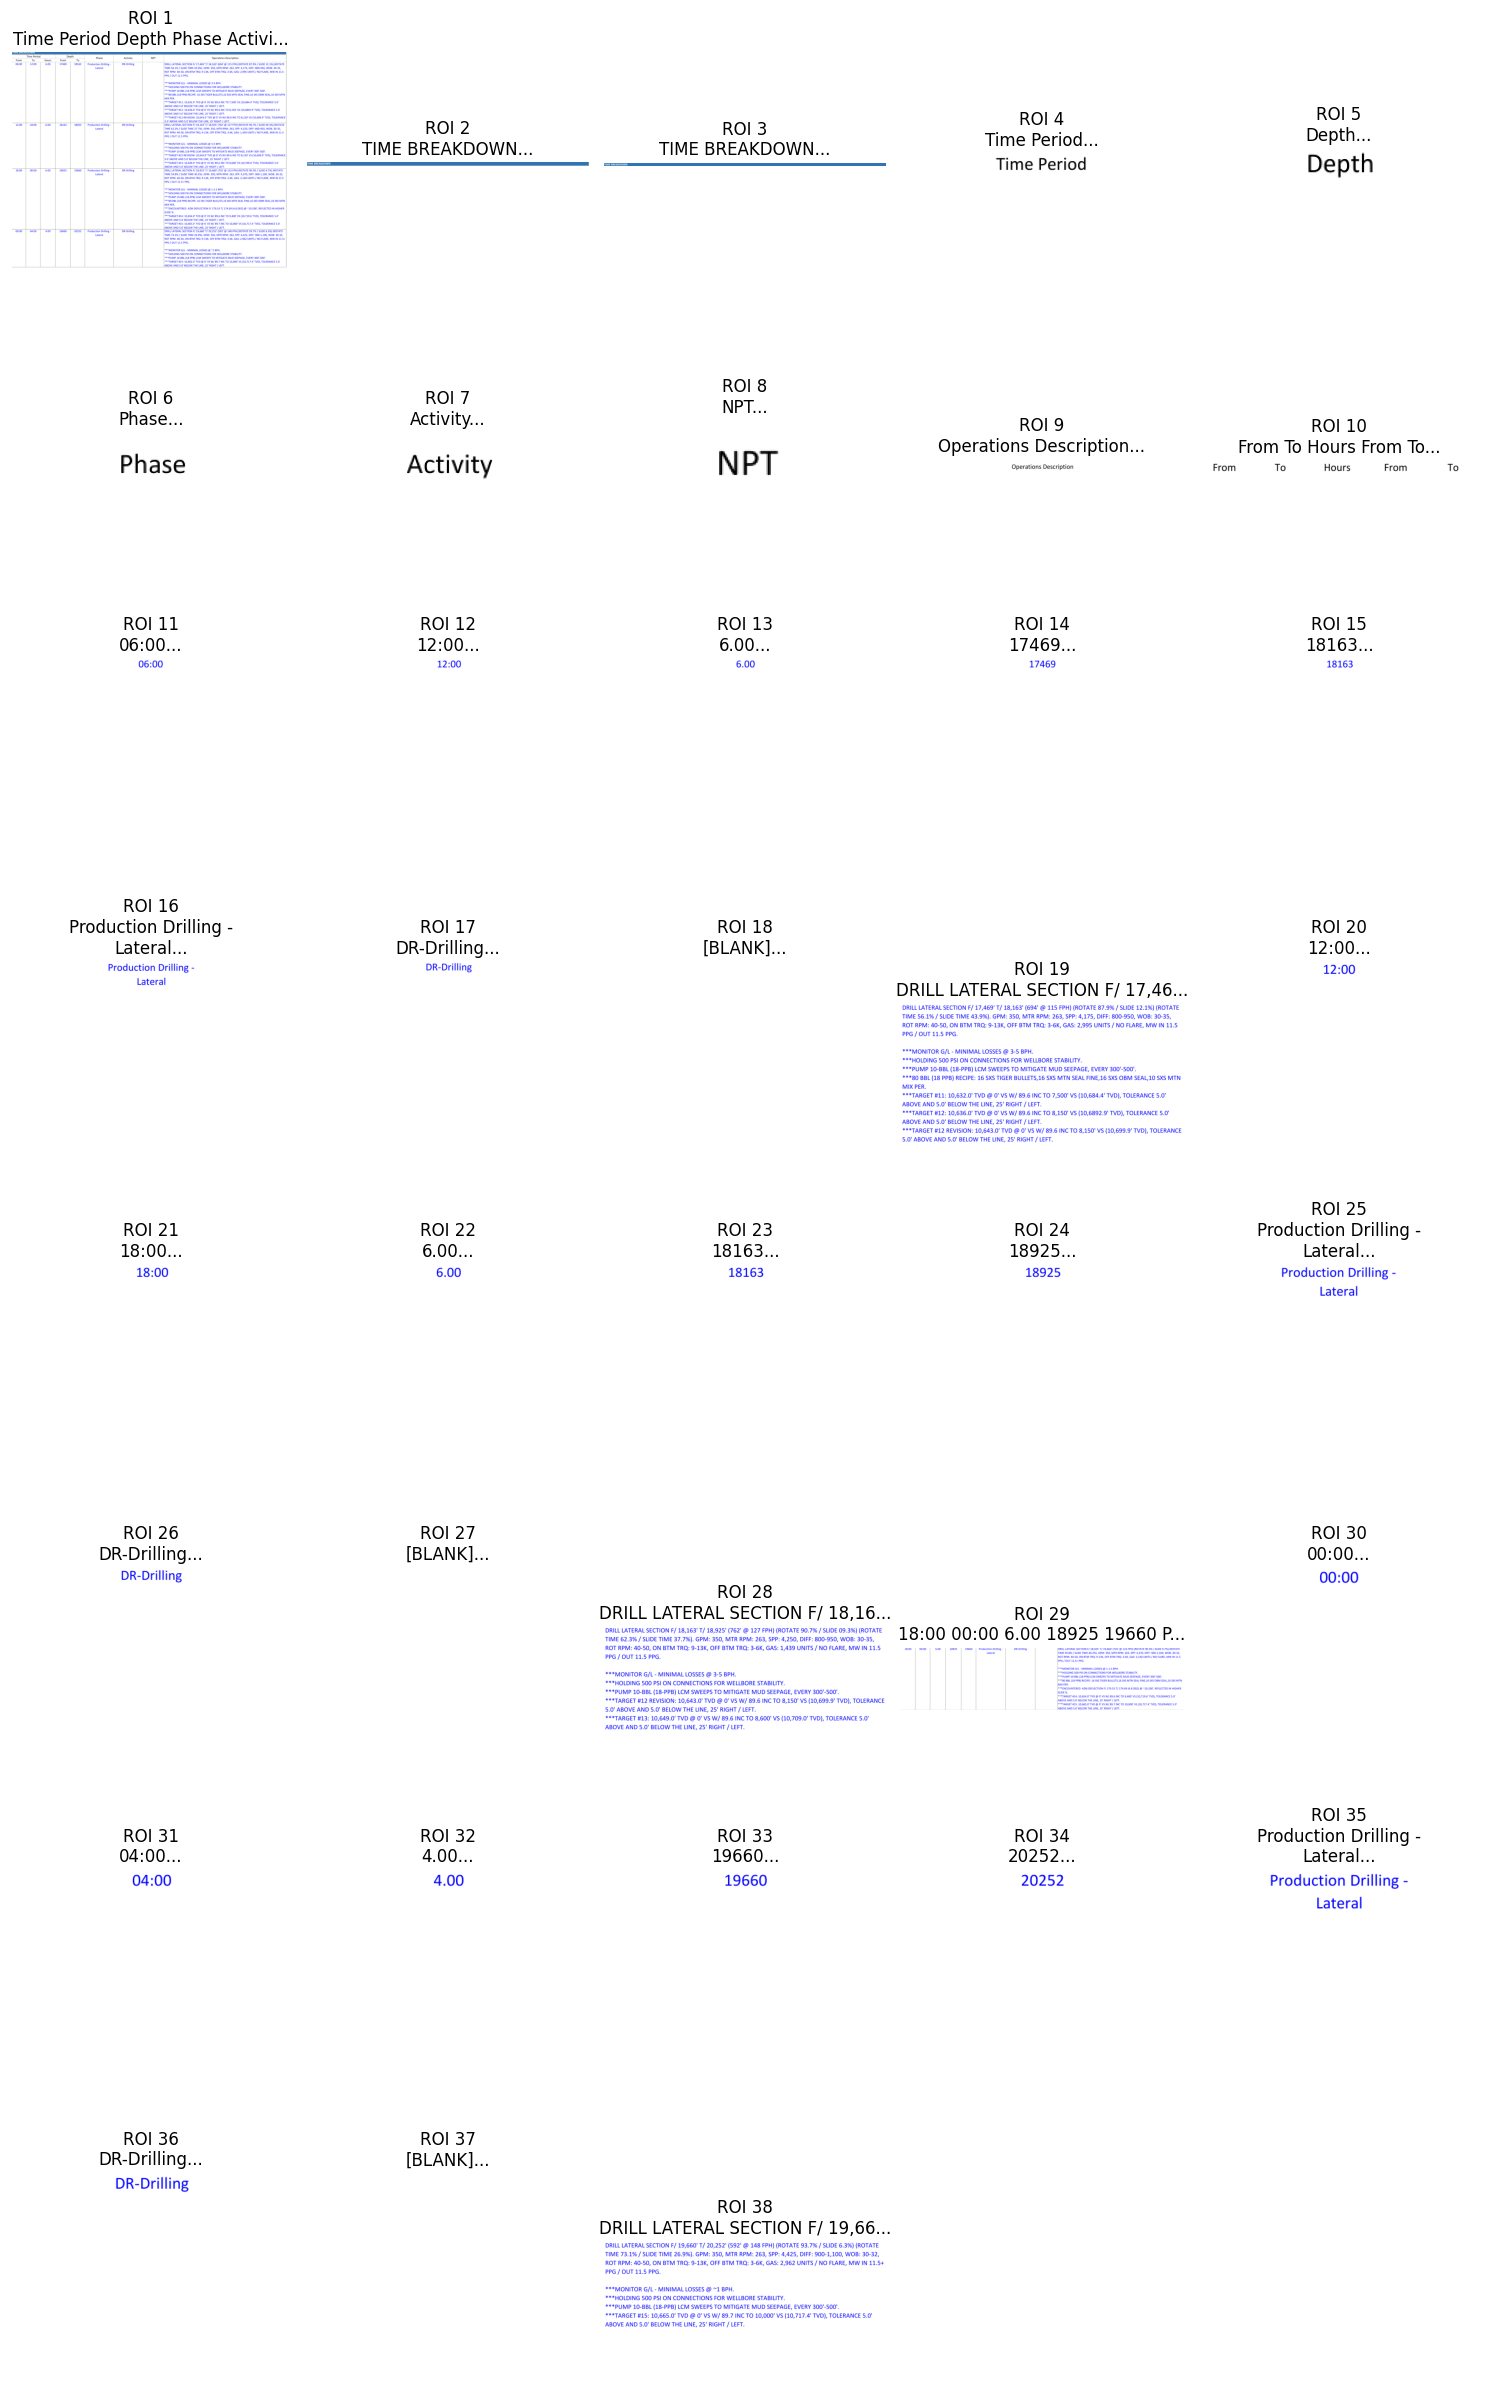

ERROR:SectionExtractor:TIME BREAKDOWN processing failed: [Errno 17] File exists: '/dbfs/mnt/mini-proj-dd/final_time_breakdown_results'


----- Extracted Time Breakdown DataFrame -----
    From  ...                Operations Description.Observations
0  06:00  ...  [MONITOR G/L - MINIMAL LOSSES @ 3-5 BPH., HOLD...
1  12:00  ...  [MONITOR G/L - MINIMAL LOSSES @ 3-5 BPH., HOLD...
2  18:00  ...  [MONITOR G/L - MINIMAL LOSSES @ 1-1.5 BPH., HO...
3  00:00  ...  [MONITOR G/L - MINIMAL LOSSES @ ~1 BPH., HOLDI...

[4 rows x 29 columns]
----- Aggregated JSON Output -----
{
    "WELL/JOB INFORMATION": {
        "Well Name": "Ross Fee 4371-31-7-15 MH",
        "Job Name": "Drilling",
        "Supervisor(s)": "CHAD MILLER / ED COOLEY",
        "Field": "XBE",
        "Sec/Twn/Rng": "31, 43N, 71W",
        "Phone": "307-315-1908",
        "AFE #": "240098",
        "API #": "49-005-78911",
        "Email": "cyclone39@aec-denver.com",
        "Contractor": "",
        "Elevation": "4913.5",
        "RKB": "27.5",
        "Spud Date": "6/4/2024",
        "Days from Spud": "7.67",
        "Days on Loc": "34",
        "MD/TVD": "20537 FT/

In [0]:
# ---------------------------------------------------------------------
# Main Process Runner
# ---------------------------------------------------------------------
def main():
    debug = False  # Set False to enable debugging output
    # Define DBFS image paths for each section
    image_paths = {
        "DAILY DRILLING REPORT": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_1.png",
        "WELL/JOB INFORMATION": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_2.png",
        "MUD": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_3.png",
        "SURVEY DATA": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_4.png",
        "DIR INFO": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_5.png",
        "DRILL BITS": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png",
        "CASING": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_7.png",
        "BOP": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_8.png",
        "PERSONNEL": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_9.png",
        "DAILY NUMBERS: OBSERVATION & INTERVENTION": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_10.png",
        "BHA": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png",
        "PUMPS": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_12.png",
        "COST DATA": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_13.png",
        "TIME BREAKDOWN": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_14.png",
        "CONSUMABLES": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_2_section_2.png"
    }
    
    # Define output folder using DBFS path directly
    output_folder = dbfs_to_local_path("dbfs:/mnt/mini-proj-dd/final_results")
    os.makedirs(output_folder, exist_ok=True)
    
    aggregated_json = {}
    aggregated_df = pd.DataFrame()
    
    # Define processing order for sections
    processes = [
        ("DAILY DRILLING REPORT", process_daily_drilling_report, image_paths.get("DAILY DRILLING REPORT")),
        ("WELL/JOB INFORMATION", process_well_job_info, image_paths.get("WELL/JOB INFORMATION")),
        ("MUD", process_mud_data, image_paths.get("MUD")),
        ("SURVEY DATA", process_survey, image_paths.get("SURVEY DATA")),
        ("DIR INFO", process_dir_info, image_paths.get("DIR INFO")),
        ("DRILL BITS", process_drill_bits, image_paths.get("DRILL BITS")),
        ("CASING", process_casing, image_paths.get("CASING")),
        ("BOP", process_bop, image_paths.get("BOP")),
        ("PERSONNEL", process_personnel, image_paths.get("PERSONNEL")),
        ("DAILY NUMBERS: OBSERVATION & INTERVENTION", process_obs_int, image_paths.get("DAILY NUMBERS: OBSERVATION & INTERVENTION")),
        ("BHA", process_bha, image_paths.get("BHA")),
        ("PUMPS", process_pumps, image_paths.get("PUMPS")),
        ("COST DATA", process_cost_data, image_paths.get("COST DATA")),
        ("TIME BREAKDOWN", process_time_breakdown, image_paths.get("TIME BREAKDOWN")),
        ("CONSUMABLES", process_consumables_data, image_paths.get("CONSUMABLES"))
    ]
    
    for section, func, img_path in processes:
        try:
            logger.info(f"Processing section: {section}")
            if img_path:
                data_json, df = func(img_path, debug)
            else:
                data_json, df = func(debug)
            # For consistency, use the section key from the returned JSON if present.
            aggregated_json[section] = data_json.get(section, data_json)
            aggregated_df = pd.concat([aggregated_df, df], ignore_index=False)
            logger.info(f"{section} output:\n{json.dumps(data_json, indent=4)}")
            save_output(section, data_json, df, output_folder)
        except Exception as e:
            logger.error(f"{section} processing failed: {e}")
    
    # Save aggregated results
    agg_json_path = os.path.join(output_folder, "aggregated_data.json")
    with open(agg_json_path, "w") as f:
        json.dump(aggregated_json, f, indent=4)
    agg_csv_path = os.path.join(output_folder, "aggregated_data.csv")
    aggregated_df.to_csv(agg_csv_path, index=False)
    logger.info(f"Aggregated JSON saved to: {agg_json_path}")
    # logger.info(f"Aggregated CSV saved to: {agg_csv_path}")
    print("----- Aggregated JSON Output -----")
    print(json.dumps(aggregated_json, indent=4))
    # print("----- Aggregated DataFrame -----")
    # print(aggregated_df)

if __name__ == "__main__":
    main()


In [0]:
import cv2
import re
import json
import os
import pandas as pd
import logging
import pytesseract
import matplotlib.pyplot as plt

# -------------------------------
# Logging Configuration
# -------------------------------
logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("SectionExtractor")

# -------------------------------
# Utility Functions
# -------------------------------

def dbfs_to_local_path(dbfs_path):
    """
    Convert a DBFS path to a local file system path.
    Example: "dbfs:/mnt/mini-proj-dd/..." becomes "/dbfs/mnt/mini-proj-dd/..."
    """
    if dbfs_path.startswith("dbfs:"):
        local_path = dbfs_path.replace("dbfs:", "/dbfs")
        return local_path
    return dbfs_path

def safe_read_image(img_path):
    """
    Reads an image from a DBFS or local path.
    """
    local_path = dbfs_to_local_path(img_path)
    logger.info(f"Attempting to read image from: {local_path}")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to read image: {local_path}")
    return img

def show_image(title, img, cmap=None, size=(10,10)):
    """
    Displays an image using matplotlib.
    """
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

def preprocess_image(img, debug=False):
    """
    Converts image to grayscale and applies adaptive thresholding.
    If image is already single-channel, it is used directly.
    """
    if len(img.shape) == 2:
        gray = img
    else:
        # If image has 3 or more channels, convert to grayscale.
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # if debug:
    #     show_image("1) Grayscale", gray, cmap="gray")
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 9
    )
    # if debug:
    #     show_image("2) Thresholded", thresh, cmap="gray")
    return thresh

def sanitize_section_name(section):
    """
    Converts section names to safe file names: lowercases, removes or replaces spaces and slashes.
    """
    # Remove slashes and replace spaces with underscores.
    sanitized = section.lower().replace("/", "_").replace(" ", "_")
    return sanitized

# -------------------------------
# Generic OCR Functions
# -------------------------------

def perform_ocr_on_rois(img, rois, debug=False):
    """
    Performs OCR on each detected text region.
    Returns a list of 5-element tuples: (x, y, w, h, text).
    """
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip()
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box ({x},{y},{w},{h}): {text}")
    return results

def detect_text_regions(thresh_img, debug=False):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        show_image("Detected Regions", debug_img)
    return rois

def group_ocr_results(roi_texts):
    """
    Groups OCR results (from 5-tuple outputs) into a list of strings.
    """
    return [text for (_, _, _, _, text) in roi_texts]

# -------------------------------
# Section-Specific Pipelines
# -------------------------------
# --- CASING Pipeline ---
def build_casing_dict_from_rois(roi_texts, expected_headers, debug=False):
    """
    Groups OCR results for CASING into rows and returns a list of dictionaries.
    """
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)
    row_strings = []
    for i, row in enumerate(rows):
        row.sort(key=lambda cell: cell[0])
        line = " ".join(cell[4] for cell in row).strip()
        row_strings.append(line)
        if debug:
            logger.info(f"Grouped Row {i}: {line}")
    all_lines = []
    for line in row_strings:
        for sub in line.split("\n"):
            sub = sub.strip()
            if sub:
                all_lines.append(sub)
    if debug:
        logger.info(f"All extracted lines: {all_lines}")
    data_lines = []
    for line in all_lines:
        tokens = re.split(r'\s{2,}', line)
        if len(tokens) == 1:
            tokens = line.split()
        if debug:
            logger.info(f"Processing line: '{line}' -> tokens: {tokens}")
        lower_tokens = [t.lower() for t in tokens]
        if "type" in lower_tokens and "size" in lower_tokens:
            logger.info(f"Skipping header line: {tokens}")
            continue
        if len(tokens) < len(expected_headers):
            logger.warning(f"Line has fewer tokens than expected: {tokens}")
            tokens = tokens + [""] * (len(expected_headers) - len(tokens))
        else:
            tokens = tokens[:len(expected_headers)]
        data_lines.append(tokens)
    casing_list = [{expected_headers[i]: tokens[i] for i in range(len(expected_headers))}
                   for tokens in data_lines]
    if debug:
        logger.info(f"Final casing list: {casing_list}")
    return casing_list

def process_casing(img_path, debug=False):
    img = safe_read_image(img_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions(thresh, debug=debug)
    logger.info(f"Detected {len(rois)} text regions for CASING")
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    expected_headers = ["Type", "Size", "Weight", "Grade", "Connection", "Top MD", "Bottom MD", "TOC"]
    casing_list = build_casing_dict_from_rois(roi_texts, expected_headers, debug=debug)
    df = pd.DataFrame(casing_list)
    logger.info(f"CASING DataFrame shape: {df.shape}")
    return {"CASING": casing_list}, df

# --- BOP Pipeline ---
def perform_ocr(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray, config="--psm 6")
    return text.strip()

def extract_bop_info(ocr_text):
    patterns = {
        "Last BOP Test Date": r"Last BOP Test Date\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Last BOP Drill": r"Last BOP Drill\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Next BOP Test": r"Next BOP Test\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})"
    }
    result = {}
    for key, regex in patterns.items():
        match = re.search(regex, ocr_text, re.IGNORECASE)
        result[key] = match.group(1) if match else ""
    return result

def process_bop(img_path, debug=False):
    img = safe_read_image(img_path)
    ocr_text = perform_ocr(img)
    logger.info("BOP OCR extraction complete.")
    bop_info = extract_bop_info(ocr_text)
    df = pd.DataFrame(list(bop_info.items()), columns=["Key", "Value"])
    logger.info(f"BOP DataFrame shape: {df.shape}")
    return {"BOP": bop_info}, df

# --- CONSUMABLES Pipeline ---
def build_consumables_dict_from_rois(roi_texts, debug=False):
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)
    grouped_rows = []
    for i, row in enumerate(rows):
        row.sort(key=lambda cell: cell[0])
        line = " ".join(cell[4] for cell in row).strip()
        grouped_rows.append(line)
        if debug:
            logger.info(f"Grouped Row {i}: {line}")
    data_rows = []
    for line in grouped_rows:
        lower_line = line.lower()
        if ("consumable" in lower_line and "received" in lower_line) or "nun" in lower_line:
            continue
        if len(line.split()) < 5:
            continue
        data_rows.append(line)
    if debug:
        logger.info(f"Data rows to parse: {data_rows}")
    consumables_list = []
    for line in data_rows:
        tokens = re.split(r'\s+', line)
        if len(tokens) > 5:
            first = " ".join(tokens[:-4])
            tokens = [first] + tokens[-4:]
        if len(tokens) != 5:
            logger.warning(f"Skipping row (unexpected token count): {tokens}")
            continue
        row_dict = {
            "Consumable": tokens[0],
            "Daily Received (gal)": tokens[1],
            "Daily Used (gal)": tokens[2],
            "Cumulative Used (gal)": tokens[3],
            "Daily on Hand (gal)": tokens[4]
        }
        consumables_list.append(row_dict)
    return consumables_list

def process_consumables(img_path, debug=False):
    img = safe_read_image(img_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions(thresh, debug=debug)
    logger.info(f"Detected {len(rois)} text regions for CONSUMABLES")
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    consumables_list = build_consumables_dict_from_rois(roi_texts, debug=debug)
    df = pd.DataFrame(consumables_list)
    logger.info(f"CONSUMABLES DataFrame shape: {df.shape}")
    return {"CONSUMABLES": consumables_list}, df


ERROR:SectionExtractor:DAILY DRILLING REPORT processing failed: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-15:Bad number of channels) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1



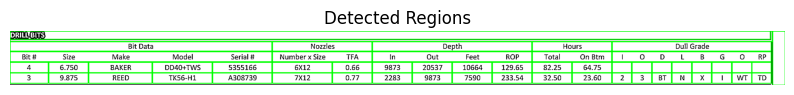

ERROR:SectionExtractor:DRILL BITS processing failed: [Errno 17] File exists: '/dbfs/mnt/mini-proj-dd/final_bit_info_results'


  Bit #   Size   Make  ... Dull Grade-G Dull Grade-O2 Dull Grade-RP
0     4  6.750  BAKER  ...      [BLANK]       [BLANK]       [BLANK]
1     3  9.875   REED  ...      [BLANK]            WT            TD

[2 rows x 21 columns]


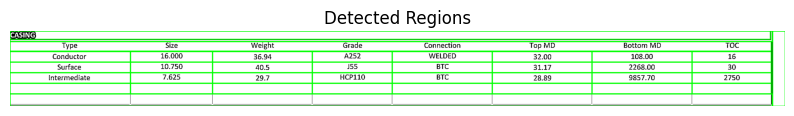

ERROR:SectionExtractor:BHA processing failed: [Errno 2] No such file or directory: '/Workspace/Repos/divya.dhaipullay@zeussolutionsinc.com/automate_ddr/dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png'


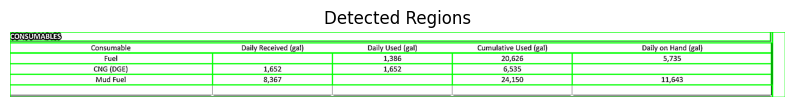

{
    "WELL/JOB INFORMATION": {
        "Well Name": "Ross Fee 4371-31-7-15 MH",
        "Job Name": "Drilling",
        "Supervisor(s)": "CHAD MILLER / ED COOLEY",
        "Field": "XBE",
        "Sec/Twn/Rng": "31, 43N, 71W",
        "Phone": "307-315-1908",
        "AFE #": "240098",
        "API #": "49-005-78911",
        "Email": "cyclone39@aec-denver.com",
        "Contractor": "",
        "Elevation": "4913.5",
        "RKB": "27.5",
        "Spud Date": "6/4/2024",
        "Days from Spud": "7.67",
        "Days on Loc": "34",
        "MD/TVD": "20537 FT/10719 FT",
        "24 Hr Footage": "3068",
        "Present Operations": "DRILLING LATERAL @ 20,537'.",
        "Activity Planned": "DRILL LATERAL SECTION TO PLANNED TD @ ~21,226', PUMP TD SWEEPS & CHC, SOOH & L/D DRILL PIPE."
    },
    "CASING": [
        {
            "Type": "CASING",
            "Size": "CASING",
            "Weight": "[BLANK]",
            "Grade": "",
            "Connection": "",
            "Top MD":

In [0]:
import cv2
import re
import json
import os
import pandas as pd
import logging
import pytesseract
import matplotlib.pyplot as plt

# -------------------------------
# Logging Configuration
# -------------------------------
logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("SectionExtractor")

# -------------------------------
# Utility Functions
# -------------------------------

def dbfs_to_local_path(dbfs_path):
    """
    Convert a DBFS path to a local file system path.
    For example, if DBFS is mounted under /dbfs, then:
      "dbfs:/mnt/mini-proj-dd/..." becomes "/dbfs/mnt/mini-proj-dd/..."
    """
    if dbfs_path.startswith("dbfs:"):
        local_path = dbfs_path.replace("dbfs:", "/dbfs")
        return local_path
    return dbfs_path

def safe_read_image(img_path):
    """
    Reads an image from a DBFS or local path.
    """
    local_path = dbfs_to_local_path(img_path)
    logger.info(f"Attempting to read image from: {local_path}")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to read image: {local_path}")
    return img

def show_image(title, img, cmap=None, size=(10,10)):
    """
    Displays an image using matplotlib.
    """
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

def preprocess_image(img, debug=False):
    """
    Converts image to grayscale and applies adaptive thresholding.
    If image already has 1 channel, it is used directly.
    """
    if len(img.shape) == 2:
        gray = img
    elif len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected number of channels in input image.")
    # if debug:
    #     show_image("1) Grayscale", gray, cmap="gray")
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)
    # if debug:
    #     show_image("2) Thresholded", thresh, cmap="gray")
    return thresh

def sanitize_section_name(section):
    """
    Converts section names to safe file names.
    """
    return section.lower().replace(" ", "_").replace("/", "_")

# -------------------------------
# Generic OCR Functions
# -------------------------------

def perform_ocr_on_rois(img, rois, debug=False):
    """
    Performs OCR on each detected text region.
    Returns a list of 5-element tuples: (x, y, w, h, text).
    """
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip()
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box ({x},{y},{w},{h}): {text}")
    return results

def detect_text_regions(thresh_img, debug=False):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        show_image("Detected Regions", debug_img)
    return rois

def group_ocr_results(roi_texts):
    """
    Groups OCR results (from 5-tuple outputs) into a list of strings.
    """
    return [text for (_, _, _, _, text) in roi_texts]

# -------------------------------
# Section-Specific Pipelines
# -------------------------------

# CASING Pipeline
def build_casing_dict_from_rois(roi_texts, expected_headers, debug=False):
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)
    row_strings = []
    for i, row in enumerate(rows):
        row.sort(key=lambda cell: cell[0])
        line = " ".join(cell[4] for cell in row).strip()
        row_strings.append(line)
        if debug:
            logger.info(f"Grouped Row {i}: {line}")
    all_lines = []
    for line in row_strings:
        for sub in line.split("\n"):
            sub = sub.strip()
            if sub:
                all_lines.append(sub)
    if debug:
        logger.info(f"All extracted lines: {all_lines}")
    data_lines = []
    for line in all_lines:
        tokens = re.split(r'\s{2,}', line)
        if len(tokens) == 1:
            tokens = line.split()
        if debug:
            logger.info(f"Processing line: '{line}' -> tokens: {tokens}")
        lower_tokens = [t.lower() for t in tokens]
        if "type" in lower_tokens and "size" in lower_tokens:
            logger.info(f"Skipping header line: {tokens}")
            continue
        if len(tokens) < len(expected_headers):
            logger.warning(f"Line has fewer tokens than expected: {tokens}")
            tokens = tokens + [""] * (len(expected_headers) - len(tokens))
        else:
            tokens = tokens[:len(expected_headers)]
        data_lines.append(tokens)
    casing_list = [{expected_headers[i]: tokens[i] for i in range(len(expected_headers))}
                   for tokens in data_lines]
    if debug:
        logger.info(f"Final casing list: {casing_list}")
    return casing_list

def process_casing(img_path, debug=False):
    img = safe_read_image(img_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions(thresh, debug=debug)
    logger.info(f"Detected {len(rois)} text regions for CASING")
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    expected_headers = ["Type", "Size", "Weight", "Grade", "Connection", "Top MD", "Bottom MD", "TOC"]
    casing_list = build_casing_dict_from_rois(roi_texts, expected_headers, debug=debug)
    df = pd.DataFrame(casing_list)
    logger.info(f"CASING DataFrame shape: {df.shape}")
    return {"CASING": casing_list}, df

# BOP Pipeline
def perform_ocr(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray, config="--psm 6")
    return text.strip()

def extract_bop_info(ocr_text):
    patterns = {
        "Last BOP Test Date": r"Last BOP Test Date\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Last BOP Drill": r"Last BOP Drill\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Next BOP Test": r"Next BOP Test\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})"
    }
    result = {}
    for key, regex in patterns.items():
        match = re.search(regex, ocr_text, re.IGNORECASE)
        result[key] = match.group(1) if match else ""
    return result

def process_bop(img_path, debug=False):
    img = safe_read_image(img_path)
    ocr_text = perform_ocr(img)
    logger.info("BOP OCR extraction complete.")
    bop_info = extract_bop_info(ocr_text)
    df = pd.DataFrame(list(bop_info.items()), columns=["Key", "Value"])
    logger.info(f"BOP DataFrame shape: {df.shape}")
    return {"BOP": bop_info}, df


# CONSUMABLES Pipeline
def build_consumables_dict_from_rois(roi_texts, debug=False):
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)
    grouped_rows = []
    for i, row in enumerate(rows):
        row.sort(key=lambda cell: cell[0])
        line = " ".join(cell[4] for cell in row).strip()
        grouped_rows.append(line)
        if debug:
            logger.info(f"Grouped Row {i}: {line}")
    data_rows = []
    for line in grouped_rows:
        lower_line = line.lower()
        if ("consumable" in lower_line and "received" in lower_line) or "nun" in lower_line:
            continue
        if len(line.split()) < 5:
            continue
        data_rows.append(line)
    if debug:
        logger.info(f"Data rows to parse: {data_rows}")
    consumables_list = []
    for line in data_rows:
        tokens = re.split(r'\s+', line)
        if len(tokens) > 5:
            first = " ".join(tokens[:-4])
            tokens = [first] + tokens[-4:]
        if len(tokens) != 5:
            logger.warning(f"Skipping row (unexpected token count): {tokens}")
            continue
        row_dict = {
            "Consumable": tokens[0],
            "Daily Received (gal)": tokens[1],
            "Daily Used (gal)": tokens[2],
            "Cumulative Used (gal)": tokens[3],
            "Daily on Hand (gal)": tokens[4]
        }
        consumables_list.append(row_dict)
    return consumables_list

def process_consumables(img_path, debug=False):
    img = safe_read_image(img_path)
    thresh = preprocess_image(img, debug=debug)
    rois = detect_text_regions(thresh, debug=debug)
    logger.info(f"Detected {len(rois)} text regions for CONSUMABLES")
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    consumables_list = build_consumables_dict_from_rois(roi_texts, debug=debug)
    df = pd.DataFrame(consumables_list)
    logger.info(f"CONSUMABLES DataFrame shape: {df.shape}")
    return {"CONSUMABLES": consumables_list}, df

# -------------------------------
# Aggregator Main Process
# -------------------------------

def main():
    debug = True  # Set True for verbose logging.
    
    # Define image paths for sections.
    image_paths = {
        "DAILY DRILLING REPORT": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_1.png",
        "WELL/JOB INFORMATION": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_2.png",
        "DRILL BITS": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png",
        "CASING": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_7.png",
        "BOP": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_8.png",
        "PERSONNEL": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_9.png",
        "BHA": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png",
        "PUMPS": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_12.png",
        "CONSUMABLES": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_2_section_2.png"
    }
    
    # Define output folder.
    output_folder = dbfs_to_local_path("dbfs:/mnt/mini-proj-dd/final_results")
    os.makedirs(output_folder, exist_ok=True)
    
    aggregated_json = {}
    aggregated_df = pd.DataFrame()
    
    # Define processing order.
    processes = [
        ("DAILY DRILLING REPORT", process_daily_drilling_report, image_paths.get("DAILY DRILLING REPORT")),
        ("WELL/JOB INFORMATION", process_well_job_info, image_paths.get("WELL/JOB INFORMATION")),
        ("DRILL BITS", process_drill_bits, image_paths.get("DRILL BITS")),
        ("CASING", process_casing, image_paths.get("CASING")),
        ("BOP", process_bop, image_paths.get("BOP")),
        ("PERSONNEL", process_personnel, image_paths.get("PERSONNEL")),
        ("BHA", process_bha, image_paths.get("BHA")),
        ("PUMPS", process_pumps, image_paths.get("PUMPS")),
        ("CONSUMABLES", process_consumables, image_paths.get("CONSUMABLES"))
    ]
    
    for section, func, img_path in processes:
        try:
            logger.info(f"Processing section: {section}")
            data_json, df = func(img_path, debug)
            safe_section = sanitize_section_name(section)
            aggregated_json[section] = data_json.get(section, data_json)
            aggregated_df = pd.concat([aggregated_df, df], ignore_index=True)
            logger.info(f"{section} output:\n{json.dumps(data_json, indent=4)}")
            # Save individual outputs.
            section_json_file = os.path.join(output_folder, f"{safe_section}.json")
            with open(section_json_file, "w") as f:
                json.dump(data_json, f, indent=4)
            section_csv_file = os.path.join(output_folder, f"{safe_section}.csv")
            df.to_csv(section_csv_file, index=False)
            logger.info(f"Saved {section} outputs to JSON and CSV.")
        except Exception as e:
            logger.error(f"{section} processing failed: {e}")
    
    # Save aggregated outputs.
    agg_json_path = os.path.join(output_folder, "aggregated_data.json")
    with open(agg_json_path, "w") as f:
        json.dump(aggregated_json, f, indent=4)
    agg_csv_path = os.path.join(output_folder, "aggregated_data.csv")
    aggregated_df.to_csv(agg_csv_path, index=False)
    logger.info(f"Aggregated JSON saved to: {agg_json_path}")
    logger.info("----- Aggregated JSON Output -----")
    print(json.dumps(aggregated_json, indent=4))

if __name__ == "__main__":
    main()


In [0]:
import cv2
import re
import json
import os
import pandas as pd
import logging
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# -------------------------------
# Logger Setup
# -------------------------------
logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("SectionExtractor")

# -------------------------------
# Utility Functions (Common)
# -------------------------------

def dbfs_to_local_path(dbfs_path):
    """
    Convert a DBFS path to a local file system path.
    Example: "dbfs:/mnt/mini-proj-dd/..." becomes "/dbfs/mnt/mini-proj-dd/..."
    """
    if dbfs_path.startswith("dbfs:"):
        return dbfs_path.replace("dbfs:", "/dbfs")
    return dbfs_path

def safe_read_image_cv2(image_path):
    """
    Reads an image using OpenCV from a local or DBFS path.
    """
    local_path = dbfs_to_local_path(image_path)
    logger.info(f"Reading image from: {local_path}")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"Image file not found at {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise ValueError(f"Failed to read image from {local_path}")
    return img

def safe_read_image_pil(image_path):
    """
    Reads an image using PIL from a local or DBFS path.
    """
    local_path = dbfs_to_local_path(image_path)
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"Image file not found at {local_path}")
    return Image.open(local_path)

def show_image(title, img, cmap=None, size=(10,10)):
    """
    Displays an image using matplotlib.
    """
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

def sanitize_section_name(section):
    """
    Convert a section name into a safe file name.
    """
    return section.lower().replace(" ", "_").replace("/", "_").replace(":", "")

# -------------------------------
# DDR Pipeline Functions
# -------------------------------

def read_image_ddr(image_path):
    """
    Read an image using OpenCV. If the path starts with 'dbfs:/', convert it to local.
    """
    return safe_read_image_cv2(image_path)

def draw_bounding_box_and_crop_ddr(image, coords, debug_path=None):
    """
    Crop the region defined by coords = (x, y, w, h). Optionally save a debug image.
    """
    x, y, w, h = coords
    if debug_path:
        debug_img = image.copy()
        cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.imwrite(debug_path, debug_img)
        logger.info(f"Debug image saved to: {debug_path}")
    return image[y:y+h, x:x+w]

def preprocess_image_for_ocr_ddr(image):
    """
    Preprocess image for DDR OCR:
      - Convert to grayscale (if not already)
      - Equalize histogram
      - Apply Gaussian blur
      - Adaptive thresholding
    """
    if len(image.shape) == 2:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized, (5,5), 0)
    processed = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
    return processed

def perform_ocr_ddr(image):
    """
    Run pytesseract OCR on the given image.
    """
    text = pytesseract.image_to_string(image, config="--psm 6").strip()
    return text

def extract_key_value_from_text_ddr(text, expected_keys):
    """
    Extract key-value pairs from text using regex based on expected keys.
    """
    combined = " ".join(line.strip() for line in text.splitlines() if line.strip())
    combined = re.sub(r'\s+', ' ', combined)
    result = {}
    for i, key in enumerate(expected_keys):
        if i < len(expected_keys)-1:
            next_key = expected_keys[i+1]
            pattern = rf'{re.escape(key)}\s*:\s*(.*?)(?=\s*{re.escape(next_key)}\s*:|$)'
        else:
            pattern = rf'{re.escape(key)}\s*:\s*(.*)'
        match = re.search(pattern, combined, re.IGNORECASE)
        result[key] = match.group(1).strip() if match and match.group(1).strip() else None
    return result

def clean_report_num_ddr(report_num_str):
    """
    Remove trailing punctuation from Report Num.
    """
    if not report_num_str:
        return report_num_str
    match = re.search(r'^(\d+)\.?$', report_num_str)
    return match.group(1) if match else report_num_str

def process_daily_drilling_report(image_path, debug=True):
    """
    Process the DDR section:
      1. Read image.
      2. Crop top-right region (coordinates may need adjustment).
      3. Preprocess and OCR.
      4. Extract key-value pairs.
    """
    logger.info(f"Processing DDR image from: {image_path}")
    img = read_image_ddr(image_path)
    # Coordinates for the top-right region; adjust as needed.
    coords = (1600, 0, 950, 185)
    debug_path = os.path.join("/dbfs/mnt/mini-proj-dd/final_ocr_results", "debug_top_right.png")
    cropped = draw_bounding_box_and_crop_ddr(img, coords, debug_path=debug_path)
    processed = preprocess_image_for_ocr_ddr(cropped)
    ocr_text = perform_ocr_ddr(processed)
    logger.info("DDR OCR extraction complete.")
    logger.info(f"OCR Text:\n{ocr_text}")
    expected_keys = ["Report Date", "Report Num", "Rig"]
    extracted = extract_key_value_from_text_ddr(ocr_text, expected_keys)
    if extracted.get("Report Num"):
        extracted["Report Num"] = clean_report_num_ddr(extracted["Report Num"])
    df = pd.DataFrame(list(extracted.items()), columns=["Key", "Value"])
    return {"DAILY DRILLING REPORT": extracted}, df

# -------------------------------
# BHA Extraction Functions
# -------------------------------

def extract_bha_data(image_path):
    """
    Extract BHA data using PIL and pytesseract.
    """
    image = safe_read_image_pil(image_path)
    ocr_text = pytesseract.image_to_string(image)
    patterns = {
        "Drill Pipe Detail": r"Drill Pipe Detail:\s*([^\n]+)",
        "Size": r"Size:\s*([\d.]+)\b",
        "Wt./Ft": r"Wt\./Ft:\s*([\d.]+)\b",
        "Connection": r"Connection:\s*([\w\d-]+)\b",
        "ID": r"ID:\s*([\d.]+)\b",
        "Drill Bit": r"Drill Bit:\s*([^\n;]+)",
        "Motor": r"Motor:\s*([^\n;]+)",
        "MWD Tool": r"MWD Tool:\s*([^\n;]+)",
        "Monel Collar": r"Monel Collar:\s*([^\n;]+)",
        "X-Over": r"X-Over:\s*([^\n;]+)",
        "Sub": r"Sub:\s*([^\n;]+)",
        "HWDP": r"HWDP:\s*([^\n;]+)",
        "Drill Pipe": r"Drill Pipe:\s*([\d.]+(?:\" DP)?)",
        "Reamer": r"Reamer:\s*([^\n;]+)",
        "Shock Sub": r"Shock Sub:\s*([^\n;]+)",
        "Total Length": r"Total Length:\s*(\d+)\b"
    }
    bha_data = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, ocr_text)
        if match:
            bha_data[key] = match.group(1).strip()
    if "Drill Pipe Detail" in bha_data:
        detail = bha_data["Drill Pipe Detail"]
        for remove_key in ["Size", "Wt./Ft", "Connection", "ID"]:
            if remove_key in bha_data:
                detail = re.sub(rf"{remove_key}:\s*{re.escape(bha_data[remove_key])}", "", detail).strip(",; ")
        bha_data["Drill Pipe Detail"] = detail
    structured_data = {
        "BHA": {
            "Drill Pipe Detail": bha_data.get("Drill Pipe Detail", ""),
            "Size": bha_data.get("Size", ""),
            "Wt./Ft": bha_data.get("Wt./Ft", ""),
            "Connection": bha_data.get("Connection", ""),
            "ID": bha_data.get("ID", ""),
            "BHA #4": {
                "Drill Bit": bha_data.get("Drill Bit", ""),
                "Motor": bha_data.get("Motor", ""),
                "MWD Tool": bha_data.get("MWD Tool", ""),
                "Monel Collar": bha_data.get("Monel Collar", ""),
                "X-Over": bha_data.get("X-Over", ""),
                "Sub": bha_data.get("Sub", ""),
                "HWDP": bha_data.get("HWDP", ""),
                "Drill Pipe": bha_data.get("Drill Pipe", ""),
                "Reamer": bha_data.get("Reamer", ""),
                "Shock Sub": bha_data.get("Shock Sub", "")
            },
            "Total Length": bha_data.get("Total Length", "")
        }
    }
    return structured_data

# -------------------------------
# Bit Info Pipeline Functions
# -------------------------------

def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def adaptive_threshold(image):
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)

def detect_text_regions_bit(image, debug=False):
    """
    Detects text regions for the Bit Info table.
    """
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        # show_image("Bit Info Detected Regions", debug_img)
    return rois

def perform_ocr_on_rois(image, rois, debug=False):
    results = []
    for (x, y, w, h) in rois:
        roi = image[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"Bit Info OCR Box ({x},{y},{w},{h}): {text}")
    return results

def build_bit_info_dict_from_rois(roi_texts, debug=False):
    row_tolerance = 10
    grouped_rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            grouped_rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        grouped_rows.append(current_row)
    row_strings = []
    for i, row in enumerate(grouped_rows):
        row.sort(key=lambda cell: cell[0])
        line = " ".join(cell[4] for cell in row).replace("\n", " ").strip()
        row_strings.append(line)
        if debug:
            logger.info(f"Bit Info Row {i}: {line}")
    if len(row_strings) < 3:
        logger.warning("Not enough rows found for Bit Info layout.")
        return [], pd.DataFrame()
    # Assume first two rows are header rows; data rows follow.
    data_lines = row_strings[3:]
    final_columns = [
        "Bit #", "Size", "Make", "Model", "Serial #",
        "Nozzle-(Number x Size)", "Nozzle-TFA",
        "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",
        "Hours-Total", "Hours-On Btm",
        "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L", 
        "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"
    ]
    structured_data = []
    for line in data_lines:
        tokens = line.split()
        if len(tokens) < 21:
            tokens += [""] * (21 - len(tokens))
        elif len(tokens) > 21:
            tokens = tokens[:21]
        row_dict = {final_columns[i]: tokens[i] for i in range(21)}
        structured_data.append(row_dict)
        if debug:
            logger.info(f"Bit Info Parsed row: {row_dict}")
    df = pd.DataFrame(structured_data)
    return structured_data, df

def process_bit_info(image_path, debug=False):
    img = safe_read_image_cv2(image_path)
    gray = get_grayscale(img)
    thresh = adaptive_threshold(gray)
    rois = detect_text_regions_bit(thresh, debug=debug)
    roi_texts = perform_ocr_on_rois(img, rois, debug=debug)
    bit_info_data, df = build_bit_info_dict_from_rois(roi_texts, debug=debug)
    return {"BIT INFO": bit_info_data}, df

# -------------------------------
# Aggregator Main Function
# -------------------------------

def main():
    # Define image paths for each section.
    ddr_image_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_1.png"
    bha_image_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png"
    bit_info_image_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png"
    
    # Define output folder.
    output_folder = dbfs_to_local_path("dbfs:/mnt/mini-proj-dd/final_results")
    os.makedirs(output_folder, exist_ok=True)
    
    aggregated_json = {}
    aggregated_df = pd.DataFrame()

    # Process DDR (Daily Drilling Report)
    try:
        ddr_data, ddr_df = process_daily_drilling_report(ddr_image_path, debug=True)
        aggregated_json["DDR"] = ddr_data.get("DAILY DRILLING REPORT", ddr_data)
        aggregated_df = pd.concat([aggregated_df, ddr_df], ignore_index=True)
        save_output("DDR", ddr_data, ddr_df, output_folder)
    except Exception as e:
        logger.error(f"DDR processing failed: {e}")

    # Process BHA
    try:
        bha_data = extract_bha_data(bha_image_path)
        aggregated_json["BHA"] = bha_data.get("BHA", bha_data)
        bha_df = pd.DataFrame([bha_data.get("BHA", {})])
        aggregated_df = pd.concat([aggregated_df, bha_df], ignore_index=True)
        save_output("BHA", bha_data, bha_df, output_folder)
    except Exception as e:
        logger.error(f"BHA processing failed: {e}")

    # Process Bit Info
    try:
        bit_info_data, bit_info_df = process_bit_info(bit_info_image_path, debug=True)
        aggregated_json["Bit Info"] = bit_info_data.get("BIT INFO", bit_info_data)
        aggregated_df = pd.concat([aggregated_df, bit_info_df], ignore_index=True)
        bit_info_folder = os.path.join(output_folder, "bit_info")
        os.makedirs(bit_info_folder, exist_ok=True)
        with open(os.path.join(bit_info_folder, "bit_info_data.json"), "w") as f:
            json.dump({"BIT INFO": bit_info_data.get("BIT INFO", bit_info_data)}, f, indent=4)
        bit_info_df.to_csv(os.path.join(bit_info_folder, "bit_info_data.csv"), index=False)
        logger.info("Bit Info outputs saved.")
    except Exception as e:
        logger.error(f"Bit Info processing failed: {e}")

    # Save aggregated outputs.
    agg_json_path = os.path.join(output_folder, "aggregated_data.json")
    with open(agg_json_path, "w") as f:
        json.dump(aggregated_json, f, indent=4)
    agg_csv_path = os.path.join(output_folder, "aggregated_data.csv")
    aggregated_df.to_csv(agg_csv_path, index=False)
    logger.info("Aggregated outputs saved.")
    print(json.dumps(aggregated_json, indent=4))

if __name__ == "__main__":
    main()


{
    "DDR": {
        "Report Date": "7/4/2024",
        "Report Num": "11",
        "Rig": "Cyclone 39"
    },
    "BHA": {
        "Drill Pipe Detail": "4.5\" DP",
        "Size": "4.5",
        "Wt./Ft": "16.6",
        "Connection": "DS-42",
        "ID": "3.826",
        "BHA #4": {
            "Drill Bit": "6.75\" BAKER DD406TWS, (6X12) 0.66 TFA",
            "Motor": "5.14\" 5.25\" 5/9, 9.9, 2.0 FBH (TS), .75 RPG, FIT -.014",
            "MWD Tool": "5.35\" UBHO HF",
            "Monel Collar": "5.21\" NMPC",
            "X-Over": "5.29\" NMDC BOX X BOX",
            "Sub": "5.05\" FLOAT SUB",
            "HWDP": "4.5\" 4.5 HWDP",
            "Drill Pipe": "4.5",
            "Reamer": "5.25\" DRILL-N-REAM 6.813\"",
            "Shock Sub": "5.25\" NOV AGITATOR (NOZZLE 11)"
        },
        "Total Length": "116"
    },
    "Bit Info": [
        {
            "Bit #": "4",
            "Size": "6.750",
            "Make": "BAKER",
            "Model": "DD40+TWS",
            "Se

In [0]:

# # -------------------------------
# # Aggregator Main Process
# # -------------------------------

# def main():
#     debug = True  # Set True for verbose logging.
    
#     # Define image paths for sections.
#     image_paths = {
#         "DAILY DRILLING REPORT": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_1.png",
#         "WELL/JOB INFORMATION": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_2.png",
#         "DRILL BITS": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png",
#         "CASING": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_7.png",
#         "BOP": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_8.png",
#         "PERSONNEL": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_9.png",
#         "BHA": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png",
#         "PUMPS": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_12.png",
#         "CONSUMABLES": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_2_section_2.png"
#     }
    
#     # Define output folder.
#     output_folder = dbfs_to_local_path("dbfs:/mnt/mini-proj-dd/final_results")
#     os.makedirs(output_folder, exist_ok=True)
    
#     aggregated_json = {}
#     aggregated_df = pd.DataFrame()
    
#     # Define processing order: each tuple contains section name, processing function, and image path.
#     processes = [
#         ("DAILY DRILLING REPORT", process_daily_drilling_report, image_paths.get("DAILY DRILLING REPORT")),
#         ("WELL/JOB INFORMATION", process_well_job_info, image_paths.get("WELL/JOB INFORMATION")),
#         ("DRILL BITS", process_drill_bits, image_paths.get("DRILL BITS")),
#         ("CASING", process_casing, image_paths.get("CASING")),
#         ("BOP", process_bop, image_paths.get("BOP")),
#         ("PERSONNEL", process_personnel, image_paths.get("PERSONNEL")),
#         ("BHA", process_bha, image_paths.get("BHA")),
#         ("PUMPS", process_pumps, image_paths.get("PUMPS")),
#         ("CONSUMABLES", process_consumables, image_paths.get("CONSUMABLES"))
#     ]
    
#     for section, func, img_path in processes:
#         try:
#             logger.info(f"Processing section: {section}")
#             data_json, df = func(img_path, debug)
#             # Use sanitized section name for file output.
#             safe_section = sanitize_section_name(section)
#             aggregated_json[section] = data_json.get(section, data_json)
#             aggregated_df = pd.concat([aggregated_df, df], ignore_index=True)
#             logger.info(f"{section} output:\n{json.dumps(data_json, indent=4)}")
#             # Save individual outputs.
#             section_json_file = os.path.join(output_folder, f"{safe_section}.json")
#             with open(section_json_file, "w") as f:
#                 json.dump(data_json, f, indent=4)
#             section_csv_file = os.path.join(output_folder, f"{safe_section}.csv")
#             df.to_csv(section_csv_file, index=False)
#             logger.info(f"Saved {section} outputs to JSON and CSV.")
#         except Exception as e:
#             logger.error(f"{section} processing failed: {e}")
    
#     # Save aggregated outputs.
#     agg_json_path = os.path.join(output_folder, "aggregated_data.json")
#     with open(agg_json_path, "w") as f:
#         json.dump(aggregated_json, f, indent=4)
#     agg_csv_path = os.path.join(output_folder, "aggregated_data.csv")
#     aggregated_df.to_csv(agg_csv_path, index=False)
#     logger.info(f"Aggregated JSON saved to: {agg_json_path}")
#     logger.info("----- Aggregated JSON Output -----")
#     print(json.dumps(aggregated_json, indent=4))

# if __name__ == "__main__":
#     main()


In [0]:
# import os
# import re
# import cv2
# import pytesseract
# import numpy as np
# import pandas as pd
# import logging
# import json
# import math
# import matplotlib.pyplot as plt
# from PIL import Image

# # -------------------------------
# # Logger Setup
# # -------------------------------
# logging.basicConfig(level=logging.DEBUG,
#                     format="%(asctime)s [%(levelname)s] %(message)s")
# logger = logging.getLogger("SectionExtractor")

# # -------------------------------
# # Utility Functions
# # -------------------------------
# def dbfs_to_local_path(dbfs_path):
#     """
#     Convert a DBFS URI (e.g. "dbfs:/mnt/xxx") to its local path ("/dbfs/mnt/xxx").
#     """
#     if dbfs_path.startswith("dbfs:/"):
#         return "/dbfs/" + dbfs_path[len("dbfs:/"):]
#     return dbfs_path

# def file_exists(dbfs_path):
#     """
#     Check if a file exists at the given path.
#     """
#     local_path = dbfs_to_local_path(dbfs_path)
#     return os.path.exists(local_path)

# def show_image(title, img, cmap=None, size=(10,10)):
#     plt.figure(figsize=size)
#     if cmap:
#         plt.imshow(img, cmap=cmap)
#     else:
#         if len(img.shape) == 3:
#             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         else:
#             plt.imshow(img, cmap="gray")
#     plt.title(title)
#     plt.axis("off")
#     plt.show()

# def sanitize_section_name(section):
#     return section.lower().replace(" ", "_").replace("/", "_").replace(":", "")

# # -------------------------------
# # Image Reading Functions
# # -------------------------------
# def safe_read_image_cv2(image_path):
#     local_path = dbfs_to_local_path(image_path)
#     logger.info(f"Reading image from: {local_path}")
#     if not os.path.exists(local_path):
#         raise FileNotFoundError(f"Image file not found at {local_path}")
#     img = cv2.imread(local_path)
#     if img is None:
#         raise ValueError(f"OpenCV failed to read image: {local_path}")
#     return img

# def safe_read_image_pil(image_path):
#     local_path = dbfs_to_local_path(image_path)
#     if not os.path.exists(local_path):
#         raise FileNotFoundError(f"Image file not found at {local_path}")
#     return Image.open(local_path)

# # -------------------------------
# # DDR Pipeline Functions
# # -------------------------------
# def read_image_ddr(image_path):
#     return safe_read_image_cv2(image_path)

# def draw_bounding_box_and_crop_ddr(image, coords, debug_path=None):
#     x, y, w, h = coords
#     if debug_path:
#         debug_img = image.copy()
#         cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
#         cv2.imwrite(debug_path, debug_img)
#         logger.info(f"Debug image saved to: {debug_path}")
#     return image[y:y+h, x:x+w]

# def preprocess_image_for_ocr_ddr(image):
#     # If already grayscale use it; else convert.
#     if len(image.shape) == 2:
#         gray = image
#     else:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     equalized = cv2.equalizeHist(gray)
#     blurred = cv2.GaussianBlur(equalized, (5,5), 0)
#     processed = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                        cv2.THRESH_BINARY, 11, 2)
#     return processed

# def perform_ocr_ddr(image):
#     text = pytesseract.image_to_string(image, config="--psm 6").strip()
#     return text

# def extract_key_value_from_text_ddr(text, expected_keys):
#     combined = " ".join(line.strip() for line in text.splitlines() if line.strip())
#     combined = re.sub(r'\s+', ' ', combined)
#     result = {}
#     for i, key in enumerate(expected_keys):
#         if i < len(expected_keys)-1:
#             next_key = expected_keys[i+1]
#             pattern = rf'{re.escape(key)}\s*:\s*(.*?)(?=\s*{re.escape(next_key)}\s*:|$)'
#         else:
#             pattern = rf'{re.escape(key)}\s*:\s*(.*)'
#         match = re.search(pattern, combined, re.IGNORECASE)
#         result[key] = match.group(1).strip() if match and match.group(1).strip() else None
#     return result

# def clean_report_num_ddr(report_num_str):
#     if not report_num_str:
#         return report_num_str
#     match = re.search(r'^(\d+)\.?$', report_num_str)
#     return match.group(1) if match else report_num_str

# def process_daily_drilling_report(image_path, debug=True):
#     logger.info(f"Processing DDR image from: {image_path}")
#     img = read_image_ddr(image_path)
#     # Coordinates for the top-right region (adjust as needed)
#     coords = (1600, 0, 950, 185)
#     debug_path = os.path.join(dbfs_to_local_path("dbfs:/mnt/mini-proj-dd/final_ocr_results"), "debug_top_right.png")
#     cropped = draw_bounding_box_and_crop_ddr(img, coords, debug_path=debug_path)
#     processed = preprocess_image_for_ocr_ddr(cropped)
#     ocr_text = perform_ocr_ddr(processed)
#     logger.info("DDR OCR extraction complete.")
#     logger.info(f"OCR Text:\n{ocr_text}")
#     expected_keys = ["Report Date", "Report Num", "Rig"]
#     extracted = extract_key_value_from_text_ddr(ocr_text, expected_keys)
#     if extracted.get("Report Num"):
#         extracted["Report Num"] = clean_report_num_ddr(extracted["Report Num"])
#     df = pd.DataFrame(list(extracted.items()), columns=["Key", "Value"])
#     return {"DAILY DRILLING REPORT": extracted}, df

# # -------------------------------
# # BHA Extraction Functions
# # -------------------------------
# def extract_bha_data(image_path):
#     image = safe_read_image_pil(image_path)
#     ocr_text = pytesseract.image_to_string(image)
#     patterns = {
#         "Drill Pipe Detail": r"Drill Pipe Detail:\s*([^\n]+)",
#         "Size": r"Size:\s*([\d.]+)\b",
#         "Wt./Ft": r"Wt\./Ft:\s*([\d.]+)\b",
#         "Connection": r"Connection:\s*([\w\d-]+)\b",
#         "ID": r"ID:\s*([\d.]+)\b",
#         "Drill Bit": r"Drill Bit:\s*([^\n;]+)",
#         "Motor": r"Motor:\s*([^\n;]+)",
#         "MWD Tool": r"MWD Tool:\s*([^\n;]+)",
#         "Monel Collar": r"Monel Collar:\s*([^\n;]+)",
#         "X-Over": r"X-Over:\s*([^\n;]+)",
#         "Sub": r"Sub:\s*([^\n;]+)",
#         "HWDP": r"HWDP:\s*([^\n;]+)",
#         "Drill Pipe": r"Drill Pipe:\s*([\d.]+(?:\" DP)?)",
#         "Reamer": r"Reamer:\s*([^\n;]+)",
#         "Shock Sub": r"Shock Sub:\s*([^\n;]+)",
#         "Total Length": r"Total Length:\s*(\d+)\b"
#     }
#     bha_data = {}
#     for key, pattern in patterns.items():
#         match = re.search(pattern, ocr_text)
#         if match:
#             bha_data[key] = match.group(1).strip()
#     if "Drill Pipe Detail" in bha_data:
#         detail = bha_data["Drill Pipe Detail"]
#         for remove_key in ["Size", "Wt./Ft", "Connection", "ID"]:
#             if remove_key in bha_data:
#                 detail = re.sub(rf"{remove_key}:\s*{re.escape(bha_data[remove_key])}", "", detail).strip(",; ")
#         bha_data["Drill Pipe Detail"] = detail
#     structured_data = {
#         "BHA": {
#             "Drill Pipe Detail": bha_data.get("Drill Pipe Detail", ""),
#             "Size": bha_data.get("Size", ""),
#             "Wt./Ft": bha_data.get("Wt./Ft", ""),
#             "Connection": bha_data.get("Connection", ""),
#             "ID": bha_data.get("ID", ""),
#             "BHA #4": {
#                 "Drill Bit": bha_data.get("Drill Bit", ""),
#                 "Motor": bha_data.get("Motor", ""),
#                 "MWD Tool": bha_data.get("MWD Tool", ""),
#                 "Monel Collar": bha_data.get("Monel Collar", ""),
#                 "X-Over": bha_data.get("X-Over", ""),
#                 "Sub": bha_data.get("Sub", ""),
#                 "HWDP": bha_data.get("HWDP", ""),
#                 "Drill Pipe": bha_data.get("Drill Pipe", ""),
#                 "Reamer": bha_data.get("Reamer", ""),
#                 "Shock Sub": bha_data.get("Shock Sub", "")
#             },
#             "Total Length": bha_data.get("Total Length", "")
#         }
#     }
#     return structured_data

# # -------------------------------
# # Bit Info Pipeline Functions
# # -------------------------------
# def get_grayscale(image):
#     return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# def adaptive_threshold(image):
#     return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                    cv2.THRESH_BINARY, 15, 9)

# def detect_text_regions_bit(image, debug=False):
#     contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     rois = []
#     for cnt in contours:
#         x, y, w, h = cv2.boundingRect(cnt)
#         if w > 30 and h > 15:
#             rois.append((x, y, w, h))
#     rois.sort(key=lambda b: (b[1], b[0]))
#     if debug:
#         debug_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
#         for (x, y, w, h) in rois:
#             cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
#         show_image("Bit Info Detected Regions", debug_img)
#     return rois

# def perform_ocr_on_rois_bit(img, rois, debug=False):
#     results = []
#     for (x, y, w, h) in rois:
#         roi = img[y:y+h, x:x+w]
#         text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
#         results.append((x, y, w, h, text))
#         if debug:
#             logger.info(f"Bit Info OCR Box ({x},{y},{w},{h}): {text}")
#     return results

# def build_bit_info_dict_from_rois(roi_texts, debug=False):
#     row_tolerance = 10
#     grouped_rows = []
#     current_row = []
#     prev_y = None
#     for (x, y, w, h, text) in roi_texts:
#         if prev_y is None or abs(y - prev_y) <= row_tolerance:
#             current_row.append((x, y, w, h, text))
#         else:
#             grouped_rows.append(current_row)
#             current_row = [(x, y, w, h, text)]
#         prev_y = y
#     if current_row:
#         grouped_rows.append(current_row)
#     row_strings = []
#     for i, row in enumerate(grouped_rows):
#         row.sort(key=lambda cell: cell[0])
#         line = " ".join(cell[4] for cell in row).replace("\n", " ").strip()
#         row_strings.append(line)
#         if debug:
#             logger.info(f"Bit Info Row {i}: {line}")
#     if len(row_strings) < 3:
#         logger.warning("Not enough rows found for Bit Info layout.")
#         return [], pd.DataFrame()
#     # Assume first two rows are headers; data rows start from row 3
#     data_lines = row_strings[3:]
#     final_columns = [
#         "Bit #", "Size", "Make", "Model", "Serial #",
#         "Nozzle-(Number x Size)", "Nozzle-TFA",
#         "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",
#         "Hours-Total", "Hours-On Btm",
#         "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L", 
#         "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"
#     ]
#     structured_data = []
#     for line in data_lines:
#         tokens = line.split()
#         if len(tokens) < 21:
#             tokens += [""] * (21 - len(tokens))
#         elif len(tokens) > 21:
#             tokens = tokens[:21]
#         row_dict = {final_columns[i]: tokens[i] for i in range(21)}
#         structured_data.append(row_dict)
#         if debug:
#             logger.info(f"Bit Info Parsed row: {row_dict}")
#     df = pd.DataFrame(structured_data)
#     return structured_data, df

# def process_bit_info(image_path, debug=False):
#     img = safe_read_image_cv2(image_path)
#     gray = get_grayscale(img)
#     thresh = adaptive_threshold(gray)
#     rois = detect_text_regions_bit(thresh, debug=debug)
#     roi_texts = perform_ocr_on_rois_bit(img, rois, debug=debug)
#     bit_info_data, df = build_bit_info_dict_from_rois(roi_texts, debug=debug)
#     return {"BIT INFO": bit_info_data}, df

# # -------------------------------
# # MUD Pipeline Functions
# # -------------------------------
# def read_cropped_section_image(section_path):
#     local_path = dbfs_to_local_path(section_path)
#     if not os.path.exists(local_path):
#         raise FileNotFoundError(f"File not found: {local_path}")
#     img = cv2.imread(local_path)
#     if img is None:
#         raise ValueError(f"OpenCV failed to load image: {local_path}")
#     return img

# def preprocess_image_mud(img, debug=True):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     if debug:
#         show_image("Mud: Grayscale", gray, cmap='gray', size=(10,10))
#     thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                    cv2.THRESH_BINARY, 15, 9)
#     if debug:
#         show_image("Mud: Adaptive Threshold", thresh, cmap='gray', size=(10,10))
#     return thresh

# def detect_text_regions_mud(thresh_img, debug=True):
#     contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     rois = []
#     debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
#     for cnt in contours:
#         x, y, w, h = cv2.boundingRect(cnt)
#         if w > 30 and h > 15:
#             rois.append((x, y, w, h))
#             cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
#     rois.sort(key=lambda b: (b[1], b[0]))
#     if debug:
#         show_image("Mud: Detected Text Regions", debug_img, size=(12,12))
#     return rois

# def perform_ocr_on_rois_mud(img, rois, debug=True):
#     results = []
#     for (x, y, w, h) in rois:
#         roi = img[y:y+h, x:x+w]
#         text = pytesseract.image_to_string(roi, config='--psm 6').strip() or "[BLANK]"
#         results.append((x, y, w, h, text))
#         if debug:
#             logger.info(f"Mud OCR Box: ({x},{y},{w},{h}) -> {text}")
#     return results

# def parse_value_row_tokens(expected_headers, tokens):
#     expected_token_count = (len(expected_headers) - 1) + 3
#     logger.info(f"Expected token count: {expected_token_count}, tokens: {tokens}")
#     if len(tokens) < expected_token_count:
#         tokens += ["[BLANK]"] * (expected_token_count - len(tokens))
#         logger.warning("Not enough tokens; padding with [BLANK].")
#     elif len(tokens) > expected_token_count:
#         tokens = tokens[:expected_token_count]
#         logger.warning("Too many tokens; trimming extra tokens.")
#     result = {}
#     idx = 0
#     for header in expected_headers:
#         if header == "GELS (10s/10m/30m)":
#             gels_tokens = tokens[idx:idx+3]
#             result[header] = {"10s": gels_tokens[0], "10m": gels_tokens[1], "30m": gels_tokens[2]}
#             idx += 3
#         else:
#             result[header] = tokens[idx]
#             idx += 1
#     logger.info(f"Parsed row tokens to dict: {result}")
#     return result

# def build_mud_dict_from_rois(roi_texts, expected_headers):
#     row_tolerance = 10
#     rows = []
#     current_row = []
#     prev_y = None
#     for (x, y, w, h, text) in roi_texts:
#         if prev_y is None or abs(y - prev_y) <= row_tolerance:
#             current_row.append((x, y, w, h, text))
#         else:
#             rows.append(current_row)
#             current_row = [(x, y, w, h, text)]
#         prev_y = y
#     if current_row:
#         rows.append(current_row)
#     row_strings = []
#     for i, row in enumerate(rows):
#         row.sort(key=lambda cell: cell[0])
#         line = " ".join(cell[4] for cell in row)
#         row_strings.append(line)
#         logger.info(f"Mud Row {i}: {line}")
#     # Expect header rows and data rows (adjust indices as per your layout)
#     header1_line = None
#     value1_line = None
#     header2_line = None
#     value2_line = None
#     for i, r_text in enumerate(row_strings):
#         if "type" in r_text.lower() and not header1_line:
#             header1_line = r_text
#             if i+1 < len(row_strings):
#                 value1_line = row_strings[i+1]
#         elif header1_line and not header2_line and any(kw in r_text.lower() for kw in ["rpm", "mud", "loss", "comments"]):
#             header2_line = r_text
#             if i+1 < len(row_strings):
#                 value2_line = row_strings[i+1]
#             break
#     logger.info(f"Mud Header1: {header1_line}")
#     logger.info(f"Mud Value1: {value1_line}")
#     logger.info(f"Mud Header2: {header2_line}")
#     logger.info(f"Mud Value2: {value2_line}")
#     if value1_line is None:
#         logger.error("No data row found for Mud section!")
#         return {}
#     tokens1 = value1_line.split()
#     tokens2 = value2_line.split() if value2_line else []
#     combined_tokens = tokens1 + tokens2
#     logger.info(f"Mud Combined Tokens: {combined_tokens}")
#     return parse_value_row_tokens(expected_headers, combined_tokens)

# def process_mud(image_path, debug=True):
#     img = read_cropped_section_image(image_path)
#     show_image("Mud Original", img, size=(12,12))
#     thresh_img = preprocess_image_mud(img, debug=debug)
#     rois = detect_text_regions_mud(thresh_img, debug=debug)
#     roi_texts = perform_ocr_on_rois_mud(img, rois, debug=debug)
#     expected_headers = [
#         "Type", "Weight In", "Weight Out", "pH", "CAKE",
#         "GELS (10s/10m/30m)", "Oil/Water", "FV", "ES", "PV",
#         "YP", "CL", "Ca", "LGS", "WL", "HTHP Loss", "3 RPM",
#         "6 RPM", "Mud Pits and Hole Volume", "24 Hr Loss",
#         "Total Loss", "Comments"
#     ]
#     mud_dict = build_mud_dict_from_rois(roi_texts, expected_headers)
#     final_dict = {"MUD": mud_dict}
#     logger.info("Final Mud Dictionary:")
#     logger.info(json.dumps(final_dict, indent=4))
#     df_final = pd.DataFrame(list(mud_dict.items()), columns=["Key", "Value"]) if isinstance(mud_dict, dict) else pd.DataFrame(mud_dict)
#     return {"MUD": mud_dict}, df_final

# # -------------------------------
# # Aggregator Main Process
# # -------------------------------
# def main():
#     debug = True  # Set True for verbose logging.
    
#     # Define image paths for sections.
#     image_paths = {
#         "DAILY DRILLING REPORT": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_1.png",
#         "WELL/JOB INFORMATION": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_2.png",  # Assume implemented elsewhere
#         "DRILL BITS": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png",
#         "CASING": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_7.png",             # Assume implemented elsewhere
#         "BOP": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_8.png",                # Assume implemented elsewhere
#         "PERSONNEL": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_9.png",            # Assume implemented elsewhere
#         "BHA": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png",
#         "PUMPS": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_12.png",              # Assume implemented elsewhere
#         "CONSUMABLES": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_2_section_2.png",
#         "MUD": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_3.png"
#     }
    
#     # Define output folder.
#     output_folder = dbfs_to_local_path("dbfs:/mnt/mini-proj-dd/final_results")
#     os.makedirs(output_folder, exist_ok=True)
    
#     aggregated_json = {}
#     aggregated_df = pd.DataFrame()
    
#     # Define processing order with available functions.
#     processes = [
#         ("DAILY DRILLING REPORT", process_daily_drilling_report, image_paths.get("DAILY DRILLING REPORT")),
#         ("WELL/JOB INFORMATION", lambda p, d: ({"WELL/JOB INFORMATION": {}}, pd.DataFrame()), image_paths.get("WELL/JOB INFORMATION")),
#         ("DRILL BITS", lambda p, d: ({"DRILL BITS": {}}, pd.DataFrame()), image_paths.get("DRILL BITS")),
#         ("CASING", lambda p, d: ({"CASING": {}}, pd.DataFrame()), image_paths.get("CASING")),
#         ("BOP", lambda p, d: ({"BOP": {}}, pd.DataFrame()), image_paths.get("BOP")),
#         ("PERSONNEL", lambda p, d: ({"PERSONNEL": {}}, pd.DataFrame()), image_paths.get("PERSONNEL")),
#         ("BHA", lambda p, d: ({"BHA": extract_bha_data(p)}, pd.DataFrame([extract_bha_data(p).get("BHA", {})])), image_paths.get("BHA")),
#         ("PUMPS", lambda p, d: ({"PUMPS": {}}, pd.DataFrame()), image_paths.get("PUMPS")),
#         ("CONSUMABLES", lambda p, d: ({"CONSUMABLES": {}}, pd.DataFrame()), image_paths.get("CONSUMABLES")),
#         ("MUD", process_mud, image_paths.get("MUD"))
#     ]
    
#     for section, func, img_path in processes:
#         try:
#             logger.info(f"Processing section: {section}")
#             data_json, df = func(img_path, debug)
#             safe_section = sanitize_section_name(section)
#             aggregated_json[section] = data_json.get(section, data_json)
#             aggregated_df = pd.concat([aggregated_df, df], ignore_index=True)
#             logger.info(f"{section} output:\n{json.dumps(data_json, indent=4)}")
#             # Save individual outputs.
#             section_json_file = os.path.join(output_folder, f"{safe_section}.json")
#             with open(section_json_file, "w") as f:
#                 json.dump(data_json, f, indent=4)
#             section_csv_file = os.path.join(output_folder, f"{safe_section}.csv")
#             df.to_csv(section_csv_file, index=False)
#             logger.info(f"Saved {section} outputs to JSON and CSV.")
#         except Exception as e:
#             logger.error(f"{section} processing failed: {e}")
    
#     # Save aggregated outputs.
#     agg_json_path = os.path.join(output_folder, "aggregated_data.json")
#     with open(agg_json_path, "w") as f:
#         json.dump(aggregated_json, f, indent=4)
#     # agg_csv_path = os.path.join(output_folder, "aggregated_data.csv")
#     # aggregated_df.to_csv(agg_csv_path, index=False)
#     logger.info(f"Aggregated outputs saved to {agg_json_path}")
#     print("----- Aggregated JSON Output -----")
#     print(json.dumps(aggregated_json, indent=4))

# if __name__ == "__main__":
#     main()


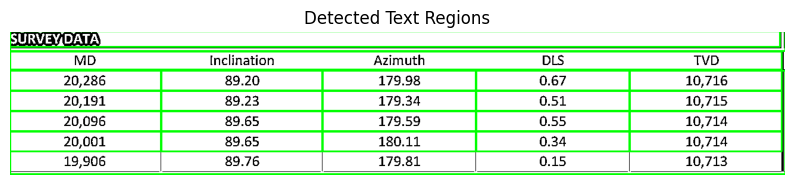

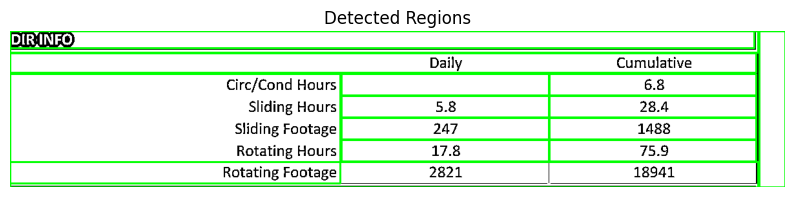

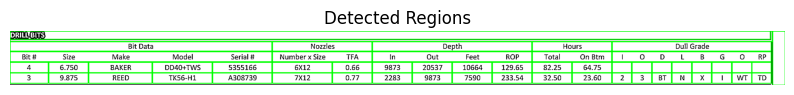

ERROR:SectionExtractor:DRILL BITS processing failed: [Errno 17] File exists: '/dbfs/mnt/mini-proj-dd/final_bit_info_results'


  Bit #   Size   Make  ... Dull Grade-G Dull Grade-O2 Dull Grade-RP
0     4  6.750  BAKER  ...      [BLANK]       [BLANK]       [BLANK]
1     3  9.875   REED  ...      [BLANK]            WT            TD

[2 rows x 21 columns]


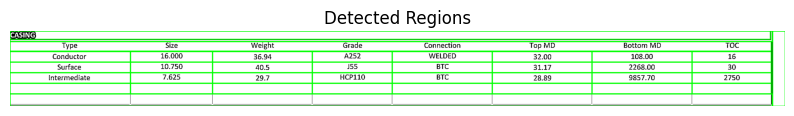

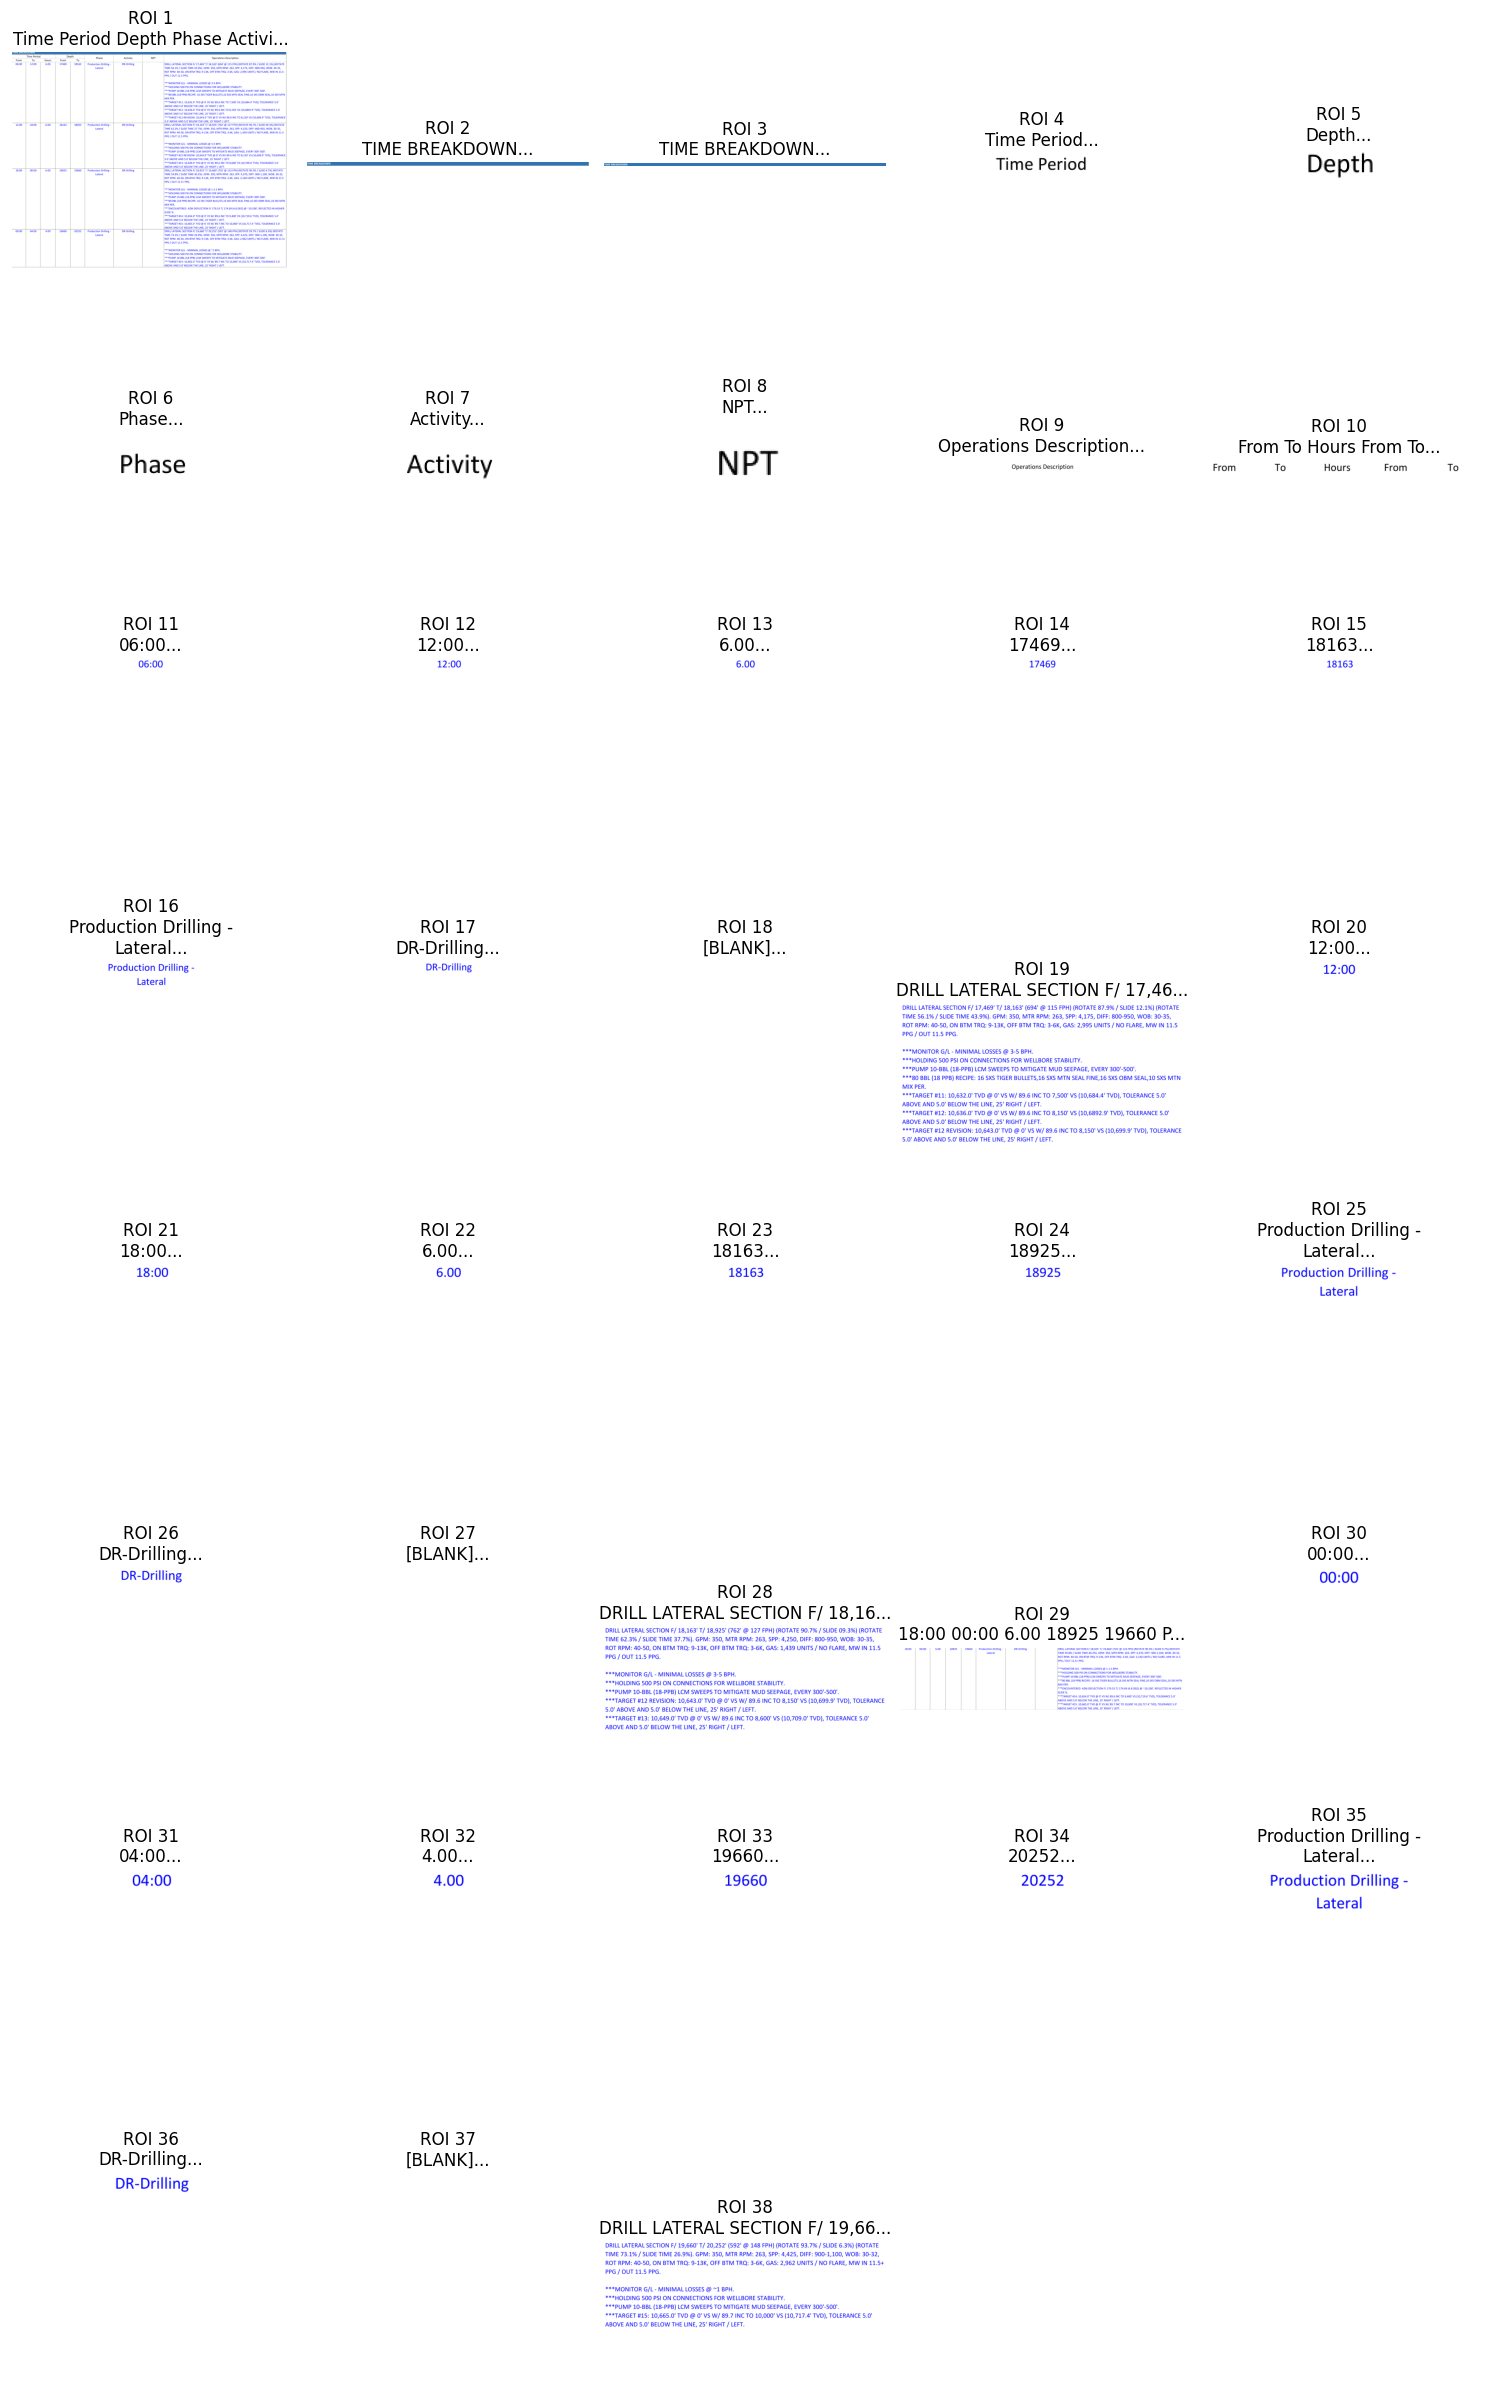

ERROR:SectionExtractor:TIME BREAKDOWN processing failed: [Errno 17] File exists: '/dbfs/mnt/mini-proj-dd/final_time_breakdown_results'


----- Extracted Time Breakdown DataFrame -----
    From  ...                Operations Description.Observations
0  06:00  ...  [MONITOR G/L - MINIMAL LOSSES @ 3-5 BPH., HOLD...
1  12:00  ...  [MONITOR G/L - MINIMAL LOSSES @ 3-5 BPH., HOLD...
2  18:00  ...  [MONITOR G/L - MINIMAL LOSSES @ 1-1.5 BPH., HO...
3  00:00  ...  [MONITOR G/L - MINIMAL LOSSES @ ~1 BPH., HOLDI...

[4 rows x 29 columns]


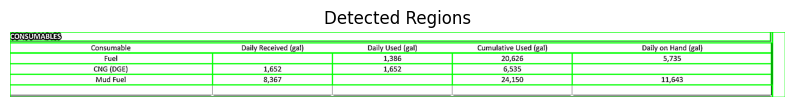

----- Aggregated JSON Output -----
{
    "DAILY DRILLING REPORT": {
        "Report Date": "7/4/2024",
        "Report Num": "11",
        "Rig": "Cyclone 39"
    },
    "WELL/JOB INFORMATION": {
        "Well Name": "Ross Fee 4371-31-7-15 MH",
        "Job Name": "Drilling",
        "Supervisor(s)": "CHAD MILLER / ED COOLEY",
        "Field": "XBE",
        "Sec/Twn/Rng": "31, 43N, 71W",
        "Phone": "307-315-1908",
        "AFE #": "240098",
        "API #": "49-005-78911",
        "Email": "cyclone39@aec-denver.com",
        "Contractor": "",
        "Elevation": "4913.5",
        "RKB": "27.5",
        "Spud Date": "6/4/2024",
        "Days from Spud": "7.67",
        "Days on Loc": "34",
        "MD/TVD": "20537 FT/10719 FT",
        "24 Hr Footage": "3068",
        "Present Operations": "DRILLING LATERAL @ 20,537'.",
        "Activity Planned": "DRILL LATERAL SECTION TO PLANNED TD @ ~21,226', PUMP TD SWEEPS & CHC, SOOH & L/D DRILL PIPE."
    },
    "MUD": {
        "Type": "O

In [0]:
import os
import re
import cv2
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import math
import matplotlib.pyplot as plt
from PIL import Image

# -------------------------------
# Logger Setup
# -------------------------------
logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("SectionExtractor")

# -------------------------------
# Utility Functions
# -------------------------------
def dbfs_to_local_path(dbfs_path):
    """Convert a DBFS URI to a local path (e.g. 'dbfs:/mnt/xxx' -> '/dbfs/mnt/xxx')."""
    if dbfs_path.startswith("dbfs:/"):
        return "/dbfs/" + dbfs_path[len("dbfs:/"):]
    return dbfs_path

# def show_image(title, img, cmap=None, size=(10,10)):
#     plt.figure(figsize=size)
#     if cmap:
#         plt.imshow(img, cmap=cmap)
#     else:
#         if len(img.shape) == 3:
#             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         else:
#             plt.imshow(img, cmap="gray")
#     plt.title(title)
#     plt.axis("off")
#     plt.show()

def sanitize_section_name(section):
    """Convert section name to a safe file name."""
    return section.lower().replace(" ", "_").replace("/", "_").replace(":", "")

# -------------------------------
# Image Reading Functions
# -------------------------------
def safe_read_image_cv2(image_path):
    local_path = dbfs_to_local_path(image_path)
    logger.info(f"Reading image from: {local_path}")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"Image file not found at {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise ValueError(f"OpenCV failed to read image: {local_path}")
    return img

def safe_read_image_pil(image_path):
    local_path = dbfs_to_local_path(image_path)
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"Image file not found at {local_path}")
    return Image.open(local_path)

# -------------------------------
# Preprocessing Functions
# -------------------------------
def preprocess_image(image, debug=False):
    """Convert to grayscale and apply adaptive thresholding."""
    if len(image.shape) == 2:
        gray = image
    elif len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected number of channels in input image.")
    # if debug:
        # show_image("Grayscale", gray, cmap="gray")
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)
    # if debug:
        # show_image("Adaptive Threshold", thresh, cmap="gray")
    return thresh

# -------------------------------
# Generic OCR Functions
# -------------------------------
def perform_ocr_on_rois(img, rois, debug=False):
    """Perform OCR on each detected region; returns list of (x,y,w,h,text)."""
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box ({x},{y},{w},{h}): {text}")
    return results

def detect_text_regions(thresh_img, debug=False):
    """Detect text regions from the thresholded image."""
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        show_image("Detected Regions", debug_img)
    return rois

# -------------------------------
# DDR Pipeline
# -------------------------------
def read_image_ddr(image_path):
    return safe_read_image_cv2(image_path)

def draw_bounding_box_and_crop_ddr(image, coords, debug_path=None):
    x, y, w, h = coords
    if debug_path:
        debug_img = image.copy()
        cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.imwrite(debug_path, debug_img)
        logger.info(f"Debug image saved to: {debug_path}")
    return image[y:y+h, x:x+w]

def preprocess_image_for_ocr_ddr(image):
    if len(image.shape) == 2:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized, (5,5), 0)
    processed = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
    return processed

def perform_ocr_ddr(image):
    return pytesseract.image_to_string(image, config="--psm 6").strip()

def extract_key_value_from_text_ddr(text, expected_keys):
    combined = " ".join(line.strip() for line in text.splitlines() if line.strip())
    combined = re.sub(r'\s+', ' ', combined)
    result = {}
    for i, key in enumerate(expected_keys):
        if i < len(expected_keys) - 1:
            next_key = expected_keys[i+1]
            pattern = rf'{re.escape(key)}\s*:\s*(.*?)(?=\s*{re.escape(next_key)}\s*:|$)'
        else:
            pattern = rf'{re.escape(key)}\s*:\s*(.*)'
        match = re.search(pattern, combined, re.IGNORECASE)
        result[key] = match.group(1).strip() if match and match.group(1).strip() else None
    return result

def clean_report_num_ddr(report_num_str):
    if not report_num_str:
        return report_num_str
    match = re.search(r'^(\d+)\.?$', report_num_str)
    return match.group(1) if match else report_num_str

def process_daily_drilling_report(image_path, debug=True):
    logger.info(f"Processing DDR image from: {image_path}")
    img = read_image_ddr(image_path)
    # Coordinates for the top-right DDR region; adjust as needed.
    coords = (1600, 0, 950, 185)
    debug_path = os.path.join(dbfs_to_local_path("dbfs:/mnt/mini-proj-dd/final_results"), "debug_top_right.png")
    cropped = draw_bounding_box_and_crop_ddr(img, coords, debug_path=debug_path)
    processed = preprocess_image_for_ocr_ddr(cropped)
    ocr_text = perform_ocr_ddr(processed)
    logger.info("DDR OCR extraction complete.")
    logger.info(f"OCR Text:\n{ocr_text}")
    expected_keys = ["Report Date", "Report Num", "Rig"]
    extracted = extract_key_value_from_text_ddr(ocr_text, expected_keys)
    if extracted.get("Report Num"):
        extracted["Report Num"] = clean_report_num_ddr(extracted["Report Num"])
    df = pd.DataFrame(list(extracted.items()), columns=["Key", "Value"])
    return {"DAILY DRILLING REPORT": extracted}, df

# -------------------------------
# MUD Pipeline
# -------------------------------
def read_cropped_section_image(section_path):
    local_path = dbfs_to_local_path(section_path)
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise ValueError(f"OpenCV failed to load image: {local_path}")
    return img

def preprocess_image_mud(img, debug=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # if debug:
    #     show_image("Mud: Grayscale", gray, cmap="gray", size=(10,10))
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)
    # if debug:
    #     show_image("Mud: Adaptive Threshold", thresh, cmap="gray", size=(10,10))
    return thresh

def detect_text_regions_mud(thresh_img, debug=True):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
    rois.sort(key=lambda b: (b[1], b[0]))
    # if debug:
    #     show_image("Mud: Detected Text Regions", debug_img, size=(12,12))
    return rois

def perform_ocr_on_rois_mud(img, rois, debug=True):
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"Mud OCR Box: ({x},{y},{w},{h}) -> {text}")
    return results

def parse_value_row_tokens(expected_headers, tokens):
    expected_token_count = (len(expected_headers) - 1) + 3
    logger.info(f"Expected token count: {expected_token_count}, tokens: {tokens}")
    if len(tokens) < expected_token_count:
        tokens += ["[BLANK]"] * (expected_token_count - len(tokens))
        logger.warning("Not enough tokens; padding with [BLANK].")
    elif len(tokens) > expected_token_count:
        tokens = tokens[:expected_token_count]
        logger.warning("Too many tokens; trimming extra tokens.")
    result = {}
    idx = 0
    for header in expected_headers:
        if header == "GELS (10s/10m/30m)":
            gels_tokens = tokens[idx:idx+3]
            result[header] = {"10s": gels_tokens[0], "10m": gels_tokens[1], "30m": gels_tokens[2]}
            idx += 3
        else:
            result[header] = tokens[idx]
            idx += 1
    logger.info(f"Parsed row tokens to dict: {result}")
    return result

def build_mud_dict_from_rois(roi_texts, expected_headers):
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)
    row_strings = []
    for i, row in enumerate(rows):
        row.sort(key=lambda cell: cell[0])
        line = " ".join(cell[4] for cell in row)
        row_strings.append(line)
        logger.info(f"Mud Row {i}: {line}")
    header1_line = None
    value1_line = None
    header2_line = None
    value2_line = None
    for i, r_text in enumerate(row_strings):
        if "type" in r_text.lower() and not header1_line:
            header1_line = r_text
            if i+1 < len(row_strings):
                value1_line = row_strings[i+1]
        elif header1_line and not header2_line and any(kw in r_text.lower() for kw in ["rpm", "mud", "loss", "comments"]):
            header2_line = r_text
            if i+1 < len(row_strings):
                value2_line = row_strings[i+1]
            break
    logger.info(f"Mud Header1: {header1_line}")
    logger.info(f"Mud Value1: {value1_line}")
    logger.info(f"Mud Header2: {header2_line}")
    logger.info(f"Mud Value2: {value2_line}")
    if value1_line is None:
        logger.error("No data row found for Mud section!")
        return {}
    tokens1 = value1_line.split()
    tokens2 = value2_line.split() if value2_line else []
    combined_tokens = tokens1 + tokens2
    logger.info(f"Mud Combined Tokens: {combined_tokens}")
    return parse_value_row_tokens(expected_headers, combined_tokens)

def process_mud(image_path, debug=True):
    img = read_cropped_section_image(image_path)
    #show_image("Mud Original", img, size=(12,12))
    thresh_img = preprocess_image_mud(img, debug=debug)
    rois = detect_text_regions_mud(thresh_img, debug=debug)
    roi_texts = perform_ocr_on_rois_mud(img, rois, debug=debug)
    expected_headers = [
        "Type", "Weight In", "Weight Out", "pH", "CAKE",
        "GELS (10s/10m/30m)", "Oil/Water", "FV", "ES", "PV",
        "YP", "CL", "Ca", "LGS", "WL", "HTHP Loss", "3 RPM",
        "6 RPM", "Mud Pits and Hole Volume", "24 Hr Loss",
        "Total Loss", "Comments"
    ]
    mud_dict = build_mud_dict_from_rois(roi_texts, expected_headers)
    return {"MUD": mud_dict}, pd.DataFrame(list(mud_dict.items()), columns=["Key", "Value"]) if isinstance(mud_dict, dict) else pd.DataFrame(mud_dict)

# -------------------------------
# BHA Pipeline
# -------------------------------
def process_bha(image_path, debug=True):
    bha_data = extract_bha_data(image_path)
    df = pd.DataFrame([bha_data.get("BHA", {})])
    return {"BHA": bha_data.get("BHA", {})}, df

# -------------------------------
# Bit Info Pipeline
# -------------------------------
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def adaptive_threshold(image):
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)

def detect_text_regions_bit(image, debug=False):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        #show_image("Bit Info Detected Regions", debug_img)
    return rois

def perform_ocr_on_rois_bit(img, rois, debug=False):
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"Bit Info OCR Box ({x},{y},{w},{h}): {text}")
    return results

def build_bit_info_dict_from_rois(roi_texts, debug=False):
    row_tolerance = 10
    grouped_rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            grouped_rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        grouped_rows.append(current_row)
    row_strings = []
    for i, row in enumerate(grouped_rows):
        row.sort(key=lambda cell: cell[0])
        line = " ".join(cell[4] for cell in row).replace("\n", " ").strip()
        row_strings.append(line)
        if debug:
            logger.info(f"Bit Info Row {i}: {line}")
    if len(row_strings) < 3:
        logger.warning("Not enough rows found for Bit Info layout.")
        return [], pd.DataFrame()
    data_lines = row_strings[3:]
    final_columns = [
        "Bit #", "Size", "Make", "Model", "Serial #",
        "Nozzle-(Number x Size)", "Nozzle-TFA",
        "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",
        "Hours-Total", "Hours-On Btm",
        "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L", 
        "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"
    ]
    structured_data = []
    for line in data_lines:
        tokens = line.split()
        if len(tokens) < 21:
            tokens += [""] * (21 - len(tokens))
        elif len(tokens) > 21:
            tokens = tokens[:21]
        row_dict = {final_columns[i]: tokens[i] for i in range(21)}
        structured_data.append(row_dict)
        if debug:
            logger.info(f"Bit Info Parsed row: {row_dict}")
    df = pd.DataFrame(structured_data)
    return structured_data, df

def process_bit_info(image_path, debug=False):
    img = safe_read_image_cv2(image_path)
    gray = get_grayscale(img)
    thresh = adaptive_threshold(gray)
    rois = detect_text_regions_bit(thresh, debug=debug)
    roi_texts = perform_ocr_on_rois_bit(img, rois, debug=debug)
    bit_info_data, df = build_bit_info_dict_from_rois(roi_texts, debug=debug)
    return {"BIT INFO": bit_info_data}, df

# -------------------------------
# Aggregator Main Process
# -------------------------------
def main():
    debug = True  # Set True for verbose logging.
    
    # Define image paths for all sections.
    image_paths = {
        "DAILY DRILLING REPORT": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_1.png",
        "WELL/JOB INFORMATION": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_2.png",
        "MUD": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_3.png",
        "SURVEY DATA": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_4.png",
        "DIR INFO": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_5.png",
        "DRILL BITS": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png",
        "CASING": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_7.png",
        "BOP": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_8.png",
        "PERSONNEL": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_9.png",
        "DAILY NUMBERS: OBSERVATION & INTERVENTION": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_10.png",
        "BHA": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png",
        "PUMPS": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_12.png",
        "COST DATA": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_13.png",
        "TIME BREAKDOWN": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_14.png",
        "CONSUMABLES": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_2_section_2.png"
    }
    
    # Define output folder.
    output_folder = dbfs_to_local_path("dbfs:/mnt/mini-proj-dd/final_results")
    os.makedirs(output_folder, exist_ok=True)
    
    aggregated_json = {}
    aggregated_df = pd.DataFrame()
    
    # Define processing order as tuples: (Section Name, processing function, image path)
    processes = [
        ("DAILY DRILLING REPORT", process_daily_drilling_report, image_paths.get("DAILY DRILLING REPORT")),
        ("WELL/JOB INFORMATION", process_well_job_info, image_paths.get("WELL/JOB INFORMATION")),
        ("MUD", process_mud, image_paths.get("MUD")),
        ("SURVEY DATA", process_survey, image_paths.get("SURVEY DATA")),
        ("DIR INFO", process_dir_info, image_paths.get("DIR INFO")),
        ("DRILL BITS", process_drill_bits, image_paths.get("DRILL BITS")),
        ("CASING", process_casing, image_paths.get("CASING")),
        ("BOP", process_bop, image_paths.get("BOP")),
        ("PERSONNEL", process_personnel, image_paths.get("PERSONNEL")),
        ("DAILY NUMBERS: OBSERVATION & INTERVENTION", lambda p, d: ({"DAILY NUMBERS: OBSERVATION & INTERVENTION": {"Observation": "None", "Intervention": "None"}}, pd.DataFrame([{"Observation": "None", "Intervention": "None"}])), image_paths.get("DAILY NUMBERS: OBSERVATION & INTERVENTION")),
        ("BHA", process_bha, image_paths.get("BHA")),
        ("PUMPS", process_pumps, image_paths.get("PUMPS")),
        ("COST DATA", process_cost_data, image_paths.get("COST DATA")),
        ("TIME BREAKDOWN", process_time_breakdown, image_paths.get("TIME BREAKDOWN")),
        ("CONSUMABLES", process_consumables, image_paths.get("CONSUMABLES"))
    ]
    
    for section, func, img_path in processes:
        try:
            logger.info(f"Processing section: {section}")
            data_json, df = func(img_path, debug)
            safe_section = sanitize_section_name(section)
            aggregated_json[section] = data_json.get(section, data_json)
            aggregated_df = pd.concat([aggregated_df, df], ignore_index=True)
            logger.info(f"{section} output:\n{json.dumps(data_json, indent=4)}")
            # Save individual outputs.
            section_json_file = os.path.join(output_folder, f"{safe_section}.json")
            with open(section_json_file, "w") as f:
                json.dump(data_json, f, indent=4)
            section_csv_file = os.path.join(output_folder, f"{safe_section}.csv")
            df.to_csv(section_csv_file, index=False)
            logger.info(f"Saved {section} outputs to JSON and CSV.")
        except Exception as e:
            logger.error(f"{section} processing failed: {e}")
    
    # Save aggregated outputs.
    agg_json_path = os.path.join(output_folder, "aggregated_data.json")
    with open(agg_json_path, "w") as f:
        json.dump(aggregated_json, f, indent=4)
    agg_csv_path = os.path.join(output_folder, "aggregated_data.csv")
    aggregated_df.to_csv(agg_csv_path, index=False)
    logger.info(f"Aggregated outputs saved to {agg_json_path} and {agg_csv_path}.")
    print("----- Aggregated JSON Output -----")
    print(json.dumps(aggregated_json, indent=4))

if __name__ == "__main__":
    main()
